In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 16

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = 0
        for _y_cls, _y_pr_cls in zip(y_cls, y_pr_cls):
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(EPOCH + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in zip(edge_y_cls, edge_pr_cls):
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(_edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(EPOCH + index / iteration)

        edge_dis_l += edge_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), edge_gen_l/(index+1), tf_gen_l/(index+1), edge_dis_l/(index+1), tf_dis_l/(index+1)

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(64, 64, 128, 256, 512), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x[1:])
        return x

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7fbdc1a81640>,)

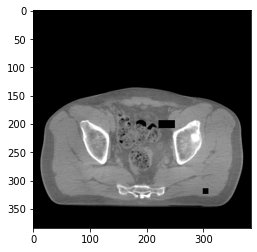

In [29]:
plt.imshow(x.squeeze(), 'gray'),

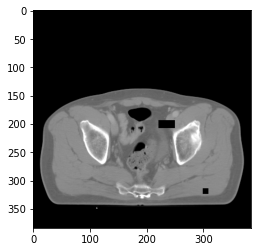

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [35]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [36]:
edge_discriminator

Discriminator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNor

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=10, T_mult=2)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=10, T_mult=2)

In [39]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [40]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis = train_a2b_epoch(model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

84it [00:43,  1.93it/s]
84it [01:28,  1.05s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.55it/s]
84it [00:41,  2.04it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.82it/s]
12it [00:04,  2.55it/s]
84it [00:41,  2.04it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.81it/s]
12it [00:04,  2.54it/s]
84it [00:41,  2.04it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.82it/s]
12it [00:04,  2.55it/s]
84it [00:41,  2.03it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.52it/s]
84it [00:41,  2.04it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.56it/s]
84it [00:41,  2.03it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.55it/s]
84it [00:41,  2.03it/s]
84it [01:29,  1.07s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.56it/s]
84it [00:41,  2.05it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.54it/s]
84it [00:41,  2.04it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.54it/s]
84it [00:41,  2.03it/s]
84it [01:29,  1.

In [41]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [42]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [43]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8706095814704895
psnr score = 25.081998825073242
snr score = 15.144937515258789
mae error = 0.0231462549418211
air dice score = 0.9952237749867374
bone dice score = 0.9381612278358193
contour dice score = 0.5092427134513855


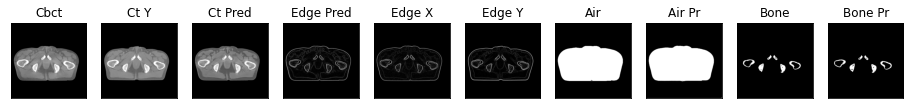

1it [00:00,  2.09it/s]

ssim score = 0.8714959621429443
psnr score = 24.9317569732666
snr score = 15.042230606079102
mae error = 0.023670991882681847
air dice score = 0.995218129866564
bone dice score = 0.9328063241116555
contour dice score = 0.5292711853981018


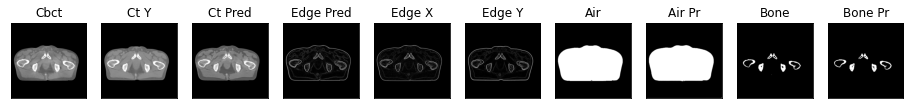

2it [00:01,  1.90it/s]

ssim score = 0.8658398389816284
psnr score = 24.39990234375
snr score = 14.673273086547852
mae error = 0.026212863624095917
air dice score = 0.9956210112911187
bone dice score = 0.9228684080837498
contour dice score = 0.5451285243034363


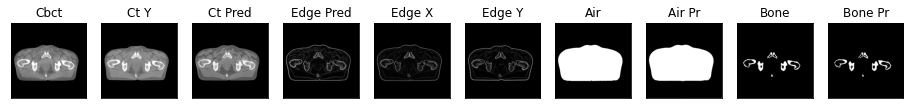

3it [00:01,  2.09it/s]

ssim score = 0.8609468340873718
psnr score = 24.30914878845215
snr score = 14.671770095825195
mae error = 0.027183424681425095
air dice score = 0.9959154749367677
bone dice score = 0.9088856271885639
contour dice score = 0.5278944373130798


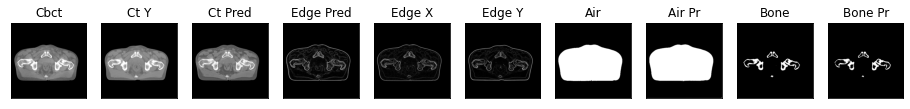

4it [00:01,  2.25it/s]

ssim score = 0.8618853688240051
psnr score = 24.279945373535156
snr score = 14.682869911193848
mae error = 0.027525300160050392
air dice score = 0.996711533333995
bone dice score = 0.8848156634046572
contour dice score = 0.5288461446762085


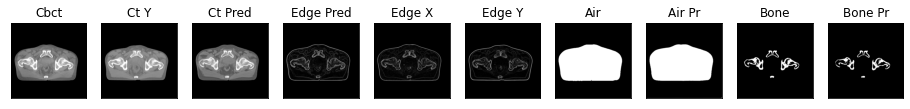

5it [00:02,  2.36it/s]

ssim score = 0.8556346297264099
psnr score = 23.81801986694336
snr score = 14.3574800491333
mae error = 0.029635515064001083
air dice score = 0.9965402040189183
bone dice score = 0.8609767229588227
contour dice score = 0.5626506209373474


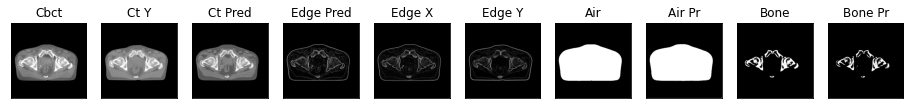

6it [00:02,  2.45it/s]

ssim score = 0.8581267595291138
psnr score = 23.874893188476562
snr score = 14.39029598236084
mae error = 0.028855184093117714
air dice score = 0.9957626696178469
bone dice score = 0.8736988202648014
contour dice score = 0.6054380536079407


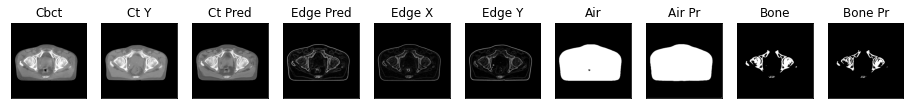

7it [00:02,  2.52it/s]

ssim score = 0.8599470853805542
psnr score = 24.39936065673828
snr score = 14.729228019714355
mae error = 0.02660895325243473
air dice score = 0.9956977385548857
bone dice score = 0.887716654108066
contour dice score = 0.543030321598053


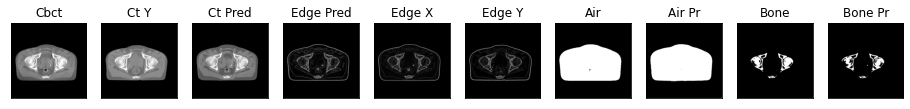

8it [00:03,  2.58it/s]

ssim score = 0.8620631098747253
psnr score = 24.700462341308594
snr score = 14.935773849487305
mae error = 0.025620970875024796
air dice score = 0.9954911790516391
bone dice score = 0.913954881214674
contour dice score = 0.5778588652610779


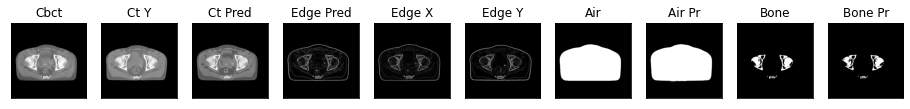

9it [00:03,  2.63it/s]

ssim score = 0.8640990257263184
psnr score = 24.73157501220703
snr score = 14.9516019821167
mae error = 0.02583436854183674
air dice score = 0.9948970792626687
bone dice score = 0.9153781863778168
contour dice score = 0.5466747879981995


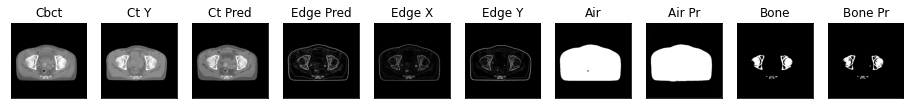

10it [00:04,  2.65it/s]

ssim score = 0.8694561123847961
psnr score = 24.793500900268555
snr score = 15.045796394348145
mae error = 0.025741279125213623
air dice score = 0.9937914793406186
bone dice score = 0.9304013194070324
contour dice score = 0.5164835453033447


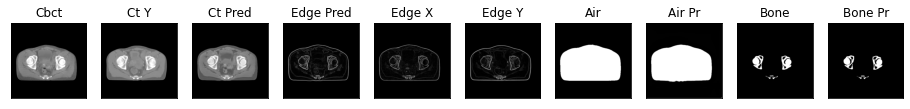

11it [00:04,  2.65it/s]

ssim score = 0.8667884469032288
psnr score = 24.31801986694336
snr score = 14.594029426574707
mae error = 0.02690921165049076
air dice score = 0.9913050627967777
bone dice score = 0.9197194076392415
contour dice score = 0.5391197800636292


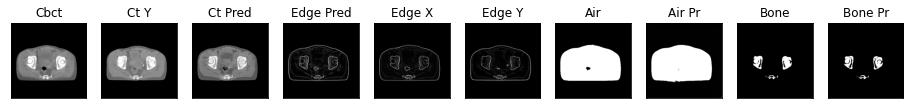

12it [00:05,  2.29it/s]

ssim score = 0.8698981404304504
psnr score = 23.826351165771484
snr score = 14.070435523986816
mae error = 0.027278579771518707
air dice score = 0.9908630707982174
bone dice score = 0.944195902991003
contour dice score = 0.5404411554336548


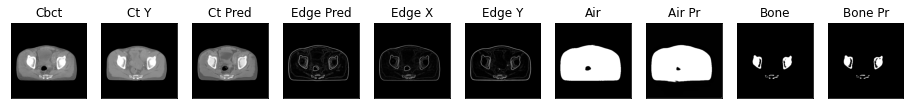

13it [00:05,  2.42it/s]

ssim score = 0.8714761137962341
psnr score = 23.80919647216797
snr score = 13.911325454711914
mae error = 0.026441028341650963
air dice score = 0.9908322244690644
bone dice score = 0.9210761188330858
contour dice score = 0.5589142441749573


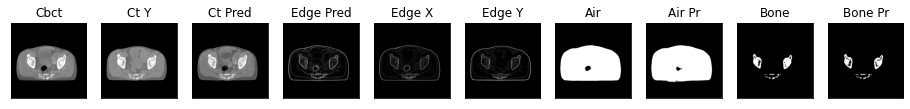

14it [00:05,  2.51it/s]

ssim score = 0.8712080121040344
psnr score = 24.0006046295166
snr score = 14.017070770263672
mae error = 0.025907697156071663
air dice score = 0.989333950435489
bone dice score = 0.9110433514528564
contour dice score = 0.5700305700302124


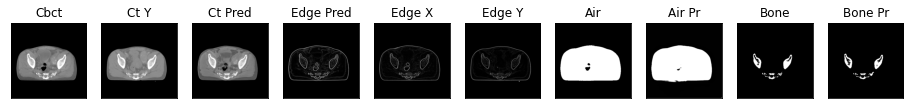

15it [00:06,  2.56it/s]

ssim score = 0.8643979430198669
psnr score = 23.657960891723633
snr score = 13.697911262512207
mae error = 0.027213694527745247
air dice score = 0.9912906955774647
bone dice score = 0.9224667349037555
contour dice score = 0.6009975075721741


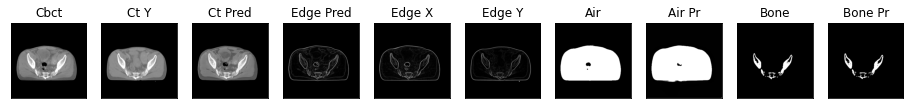

16it [00:06,  2.61it/s]

ssim score = 0.8643910884857178
psnr score = 23.127323150634766
snr score = 13.164730072021484
mae error = 0.028435582295060158
air dice score = 0.9899533587090656
bone dice score = 0.9207161125329348
contour dice score = 0.5463659167289734


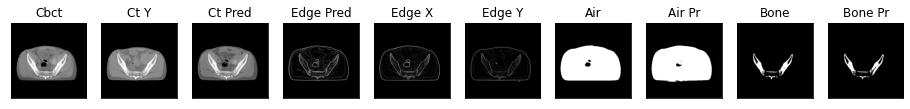

17it [00:06,  2.66it/s]

ssim score = 0.858780562877655
psnr score = 22.92230224609375
snr score = 12.857948303222656
mae error = 0.028607547283172607
air dice score = 0.9878410246424917
bone dice score = 0.9039921626266961
contour dice score = 0.5039950609207153


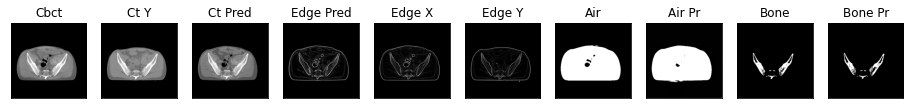

18it [00:07,  2.69it/s]

ssim score = 0.8549484014511108
psnr score = 22.806928634643555
snr score = 12.69189453125
mae error = 0.028925282880663872
air dice score = 0.9895008248571637
bone dice score = 0.9014220294058637
contour dice score = 0.559235692024231


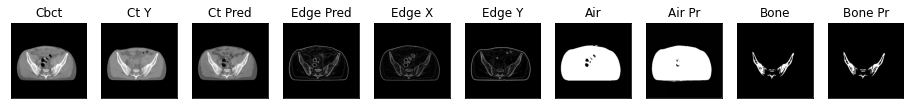

19it [00:07,  2.69it/s]

ssim score = 0.8560104966163635
psnr score = 22.523704528808594
snr score = 12.39635944366455
mae error = 0.029557794332504272
air dice score = 0.9924238247003249
bone dice score = 0.9069331667719309
contour dice score = 0.46805819869041443


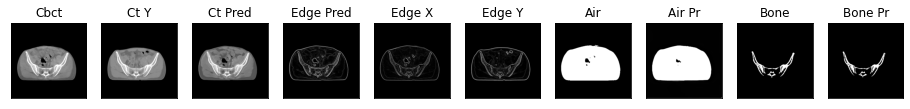

20it [00:07,  2.71it/s]

ssim score = 0.8534819483757019
psnr score = 22.40730094909668
snr score = 12.215108871459961
mae error = 0.029560284689068794
air dice score = 0.9921542404992844
bone dice score = 0.8918918918933384
contour dice score = 0.4326739013195038


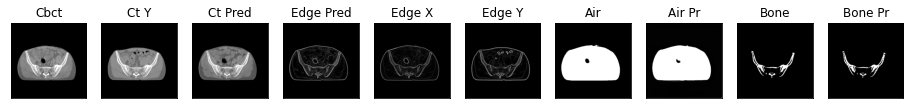

21it [00:08,  2.72it/s]

ssim score = 0.8552417159080505
psnr score = 22.556188583374023
snr score = 12.3045654296875
mae error = 0.029008634388446808
air dice score = 0.9914146231973611
bone dice score = 0.8954515491114641
contour dice score = 0.41908445954322815


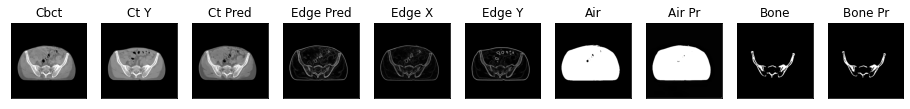

22it [00:08,  2.32it/s]

ssim score = 0.8611783981323242
psnr score = 22.762815475463867
snr score = 12.477767944335938
mae error = 0.028440088033676147
air dice score = 0.9923402516936641
bone dice score = 0.9019411396380471
contour dice score = 0.4342190623283386


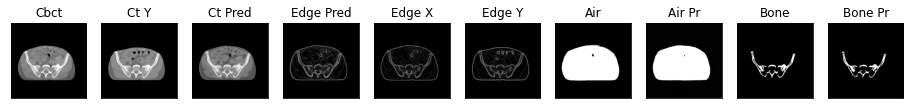

23it [00:09,  2.42it/s]

ssim score = 0.8584566116333008
psnr score = 22.695119857788086
snr score = 12.361505508422852
mae error = 0.028580188751220703
air dice score = 0.9932052295669987
bone dice score = 0.8922148461087239
contour dice score = 0.40740740299224854


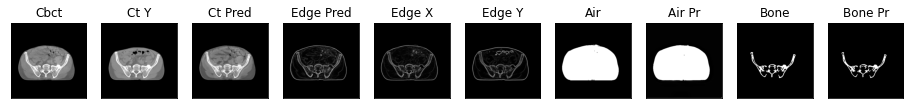

24it [00:09,  2.51it/s]

ssim score = 0.8575478792190552
psnr score = 22.594100952148438
snr score = 12.163490295410156
mae error = 0.0283677838742733
air dice score = 0.9931409704945556
bone dice score = 0.8972419411160567
contour dice score = 0.42493298649787903


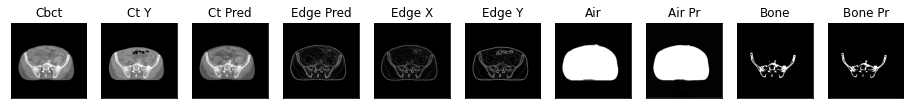

25it [00:09,  2.58it/s]

ssim score = 0.8608370423316956
psnr score = 22.77077865600586
snr score = 12.257431983947754
mae error = 0.02729891426861286
air dice score = 0.9922022431903244
bone dice score = 0.8935383192706792
contour dice score = 0.47826087474823


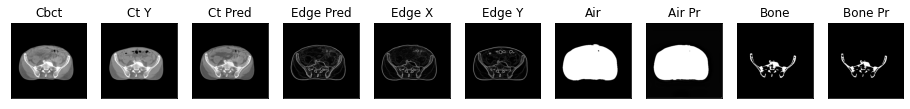

26it [00:10,  2.64it/s]

ssim score = 0.8583624958992004
psnr score = 22.855709075927734
snr score = 12.25117301940918
mae error = 0.026899375021457672
air dice score = 0.9927813574923783
bone dice score = 0.8883391431475504
contour dice score = 0.5212543606758118


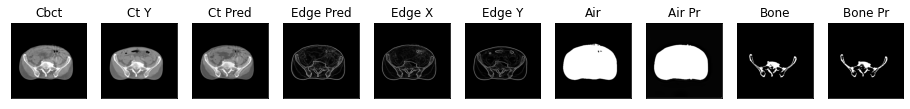

27it [00:10,  2.67it/s]

ssim score = 0.8583031296730042
psnr score = 22.8109130859375
snr score = 12.165271759033203
mae error = 0.026972521096467972
air dice score = 0.9922414004763286
bone dice score = 0.9023741083796192
contour dice score = 0.47424134612083435


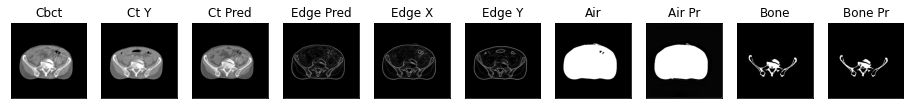

28it [00:11,  2.70it/s]

ssim score = 0.8113085031509399
psnr score = 22.75611686706543
snr score = 14.128273963928223
mae error = 0.029105765745043755
air dice score = 0.994290017716381
bone dice score = 0.962009419153469
contour dice score = 0.580534040927887


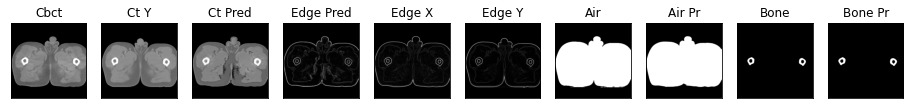

29it [00:11,  2.71it/s]

ssim score = 0.8162745833396912
psnr score = 23.179000854492188
snr score = 14.59041690826416
mae error = 0.02810291387140751
air dice score = 0.9936331443459792
bone dice score = 0.9611764705893772
contour dice score = 0.5334462523460388


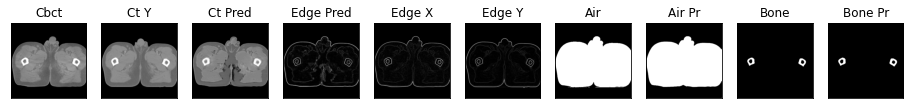

30it [00:11,  2.72it/s]

ssim score = 0.822109043598175
psnr score = 23.43299674987793
snr score = 14.93186092376709
mae error = 0.028036989271640778
air dice score = 0.9944631841249616
bone dice score = 0.9588332157149181
contour dice score = 0.529960036277771


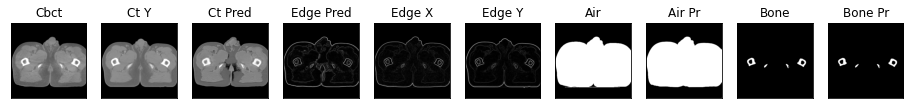

31it [00:12,  2.72it/s]

ssim score = 0.8302336931228638
psnr score = 23.6446533203125
snr score = 15.306072235107422
mae error = 0.029484424740076065
air dice score = 0.99597966253348
bone dice score = 0.9529122231344888
contour dice score = 0.568150520324707


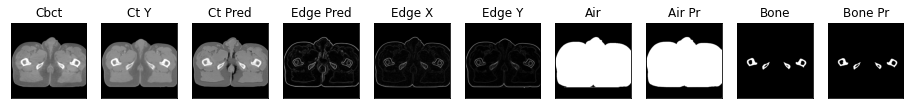

32it [00:12,  2.32it/s]

ssim score = 0.8329579830169678
psnr score = 23.554555892944336
snr score = 15.344120025634766
mae error = 0.03087647072970867
air dice score = 0.9965737545989387
bone dice score = 0.9323222206333908
contour dice score = 0.4958217144012451


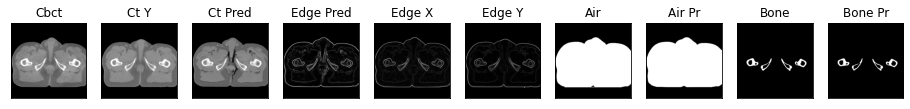

33it [00:13,  2.44it/s]

ssim score = 0.8308303356170654
psnr score = 23.655406951904297
snr score = 15.548210144042969
mae error = 0.03168280050158501
air dice score = 0.9966704461602165
bone dice score = 0.9156902699959795
contour dice score = 0.5418215394020081


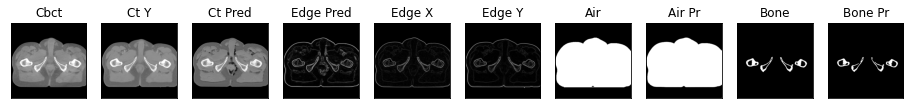

34it [00:13,  2.52it/s]

ssim score = 0.8289655447006226
psnr score = 23.51800537109375
snr score = 15.477906227111816
mae error = 0.03297043591737747
air dice score = 0.9967005379557701
bone dice score = 0.8967164179116809
contour dice score = 0.4958217144012451


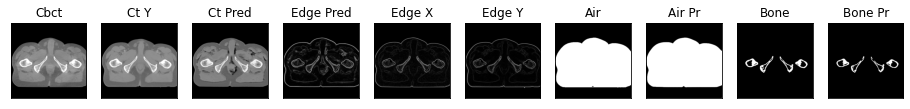

35it [00:13,  2.58it/s]

ssim score = 0.8252365589141846
psnr score = 23.690624237060547
snr score = 15.640636444091797
mae error = 0.03197145089507103
air dice score = 0.9966265749603672
bone dice score = 0.9065829314802446
contour dice score = 0.5129629373550415


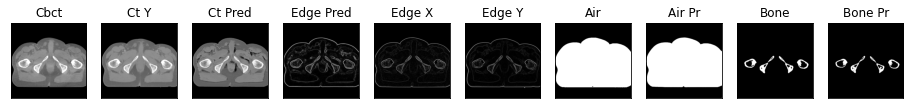

36it [00:14,  2.62it/s]

ssim score = 0.8299670815467834
psnr score = 24.041528701782227
snr score = 15.97787857055664
mae error = 0.03097372315824032
air dice score = 0.996509131564708
bone dice score = 0.910022271715924
contour dice score = 0.5025451183319092


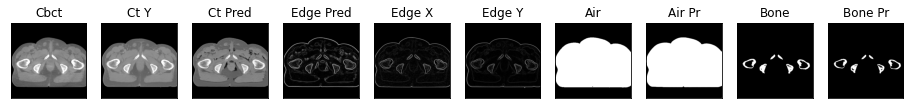

37it [00:14,  2.65it/s]

ssim score = 0.8348005414009094
psnr score = 24.518754959106445
snr score = 16.467105865478516
mae error = 0.0299618411809206
air dice score = 0.9966734781162402
bone dice score = 0.9024649133163997
contour dice score = 0.503010630607605


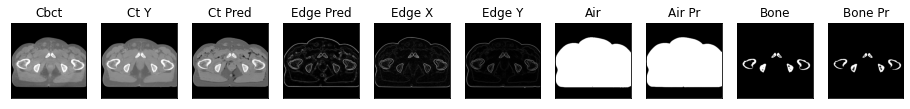

38it [00:14,  2.68it/s]

ssim score = 0.8365129828453064
psnr score = 24.45960807800293
snr score = 16.447040557861328
mae error = 0.03079458512365818
air dice score = 0.9965554103812825
bone dice score = 0.9113009989179046
contour dice score = 0.47929269075393677


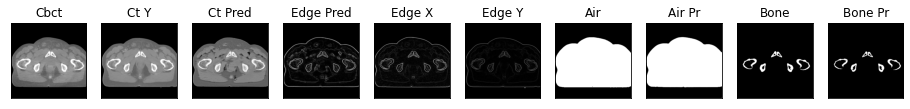

39it [00:15,  2.70it/s]

ssim score = 0.8256643414497375
psnr score = 23.443811416625977
snr score = 15.572532653808594
mae error = 0.03559079393744469
air dice score = 0.9967391498031036
bone dice score = 0.9028724943180112
contour dice score = 0.4783216714859009


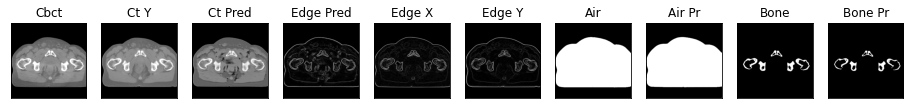

40it [00:15,  2.71it/s]

ssim score = 0.8180187940597534
psnr score = 22.22541618347168
snr score = 14.448824882507324
mae error = 0.04071003943681717
air dice score = 0.9968003615948254
bone dice score = 0.8771405989296818
contour dice score = 0.4695977568626404


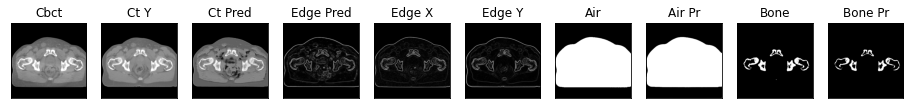

41it [00:16,  2.72it/s]

ssim score = 0.8117899298667908
psnr score = 21.9552001953125
snr score = 14.144561767578125
mae error = 0.04124470800161362
air dice score = 0.9965044559239352
bone dice score = 0.8314328648472428
contour dice score = 0.48547327518463135


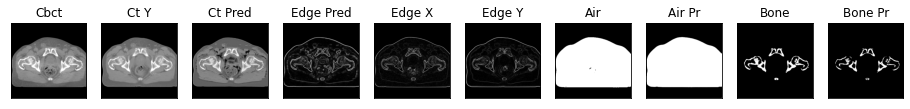

42it [00:16,  2.33it/s]

ssim score = 0.8101111054420471
psnr score = 21.4250545501709
snr score = 13.686605453491211
mae error = 0.04388420656323433
air dice score = 0.9957745719131924
bone dice score = 0.7553097699787183
contour dice score = 0.46804511547088623


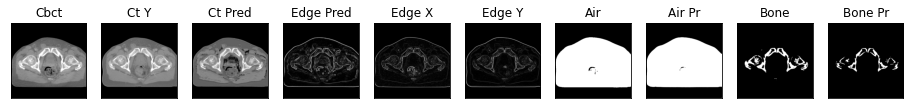

43it [00:16,  2.44it/s]

ssim score = 0.8169323801994324
psnr score = 21.660860061645508
snr score = 13.786314010620117
mae error = 0.04138845577836037
air dice score = 0.9958484254100457
bone dice score = 0.7955889724331269
contour dice score = 0.4799622893333435


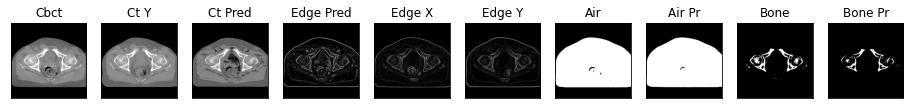

44it [00:17,  2.52it/s]

ssim score = 0.8261131048202515
psnr score = 21.95636749267578
snr score = 13.903260231018066
mae error = 0.03804734721779823
air dice score = 0.9965894205636833
bone dice score = 0.8295910619391518
contour dice score = 0.49456265568733215


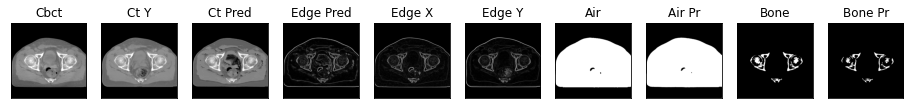

45it [00:17,  2.58it/s]

ssim score = 0.8246536254882812
psnr score = 22.635173797607422
snr score = 14.491479873657227
mae error = 0.035947807133197784
air dice score = 0.9967407013236763
bone dice score = 0.844402050794749
contour dice score = 0.49644044041633606


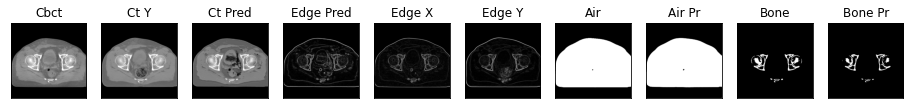

46it [00:18,  2.61it/s]

ssim score = 0.827097475528717
psnr score = 22.765491485595703
snr score = 14.63748550415039
mae error = 0.03628414124250412
air dice score = 0.9967577413479073
bone dice score = 0.8500168520407817
contour dice score = 0.5190476179122925


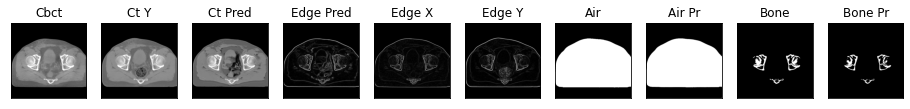

47it [00:18,  2.65it/s]

ssim score = 0.8163905739784241
psnr score = 22.838838577270508
snr score = 14.720870018005371
mae error = 0.03645138815045357
air dice score = 0.9966922175568812
bone dice score = 0.8420729209356609
contour dice score = 0.5243088603019714


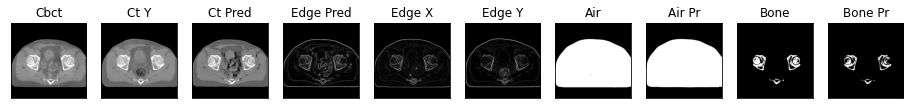

48it [00:18,  2.67it/s]

ssim score = 0.8217830061912537
psnr score = 22.891754150390625
snr score = 14.835376739501953
mae error = 0.036452751606702805
air dice score = 0.996528691861713
bone dice score = 0.8585928948168117
contour dice score = 0.5314285755157471


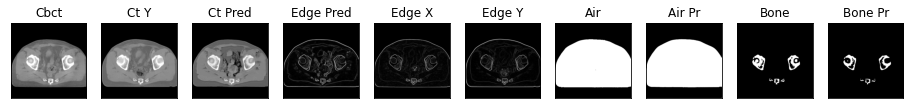

49it [00:19,  2.70it/s]

ssim score = 0.8267350196838379
psnr score = 23.159297943115234
snr score = 15.173001289367676
mae error = 0.035644758492708206
air dice score = 0.9960847366095561
bone dice score = 0.9034741784046623
contour dice score = 0.5235602259635925


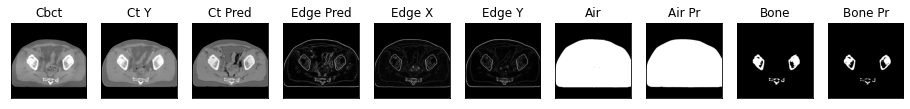

50it [00:19,  2.71it/s]

ssim score = 0.8369879722595215
psnr score = 23.2779541015625
snr score = 15.172552108764648
mae error = 0.034379128366708755
air dice score = 0.9964042461802808
bone dice score = 0.8907263973216378
contour dice score = 0.48715507984161377


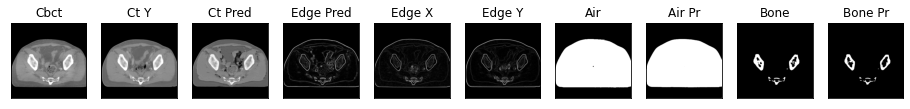

51it [00:19,  2.72it/s]

ssim score = 0.8249483108520508
psnr score = 22.892534255981445
snr score = 14.868757247924805
mae error = 0.03663313761353493
air dice score = 0.9953969586829569
bone dice score = 0.8853362734299399
contour dice score = 0.495219886302948


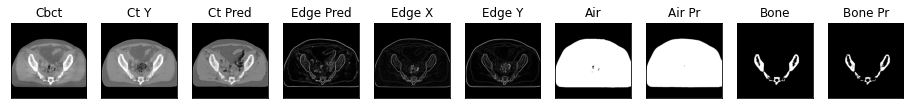

52it [00:20,  2.32it/s]

ssim score = 0.8287913203239441
psnr score = 22.964990615844727
snr score = 15.021361351013184
mae error = 0.037445537745952606
air dice score = 0.9948432191998468
bone dice score = 0.853637299138339
contour dice score = 0.48153477907180786


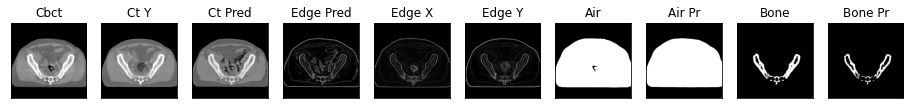

53it [00:20,  2.43it/s]

ssim score = 0.8061925172805786
psnr score = 22.255863189697266
snr score = 14.33379077911377
mae error = 0.03980846703052521
air dice score = 0.9956677731133483
bone dice score = 0.826504065042061
contour dice score = 0.4489402770996094


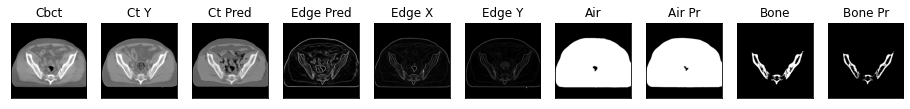

54it [00:21,  2.51it/s]

ssim score = 0.8028051853179932
psnr score = 21.859777450561523
snr score = 13.950243949890137
mae error = 0.041278939694166183
air dice score = 0.9964200260471899
bone dice score = 0.8411870210350466
contour dice score = 0.4390009641647339


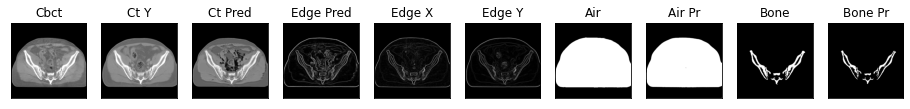

55it [00:21,  2.57it/s]

ssim score = 0.7788314819335938
psnr score = 20.88421630859375
snr score = 10.764425277709961
mae error = 0.035624369978904724
air dice score = 0.9953231141302457
bone dice score = 0.9433656957944077
contour dice score = 0.5977900624275208


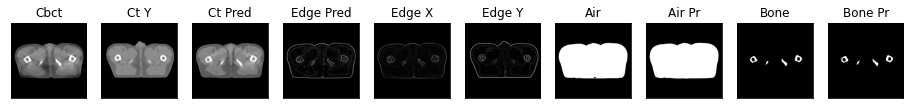

56it [00:21,  2.63it/s]

ssim score = 0.7696674466133118
psnr score = 20.418102264404297
snr score = 10.511292457580566
mae error = 0.038546495139598846
air dice score = 0.995710659674014
bone dice score = 0.9140936778005861
contour dice score = 0.5822784900665283


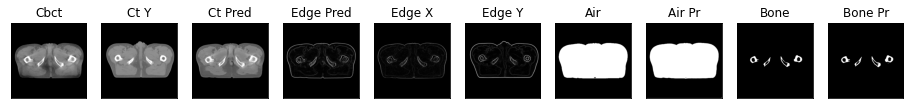

57it [00:22,  2.66it/s]

ssim score = 0.7646682262420654
psnr score = 20.353300094604492
snr score = 10.577629089355469
mae error = 0.03983030095696449
air dice score = 0.9959254076792461
bone dice score = 0.882862088865496
contour dice score = 0.5913329720497131


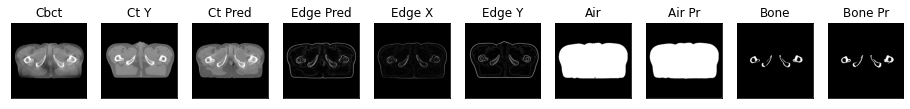

58it [00:22,  2.68it/s]

ssim score = 0.7678115963935852
psnr score = 20.61293601989746
snr score = 10.907668113708496
mae error = 0.038897860795259476
air dice score = 0.9952418089888667
bone dice score = 0.8748142644896951
contour dice score = 0.5361050367355347


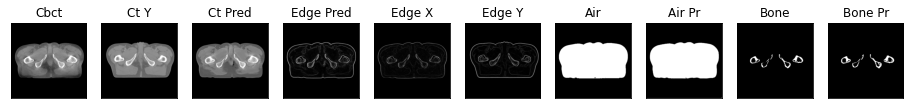

59it [00:23,  2.71it/s]

ssim score = 0.7735889554023743
psnr score = 20.75857162475586
snr score = 11.100868225097656
mae error = 0.038269706070423126
air dice score = 0.9947142644964618
bone dice score = 0.876197361289062
contour dice score = 0.5307232141494751


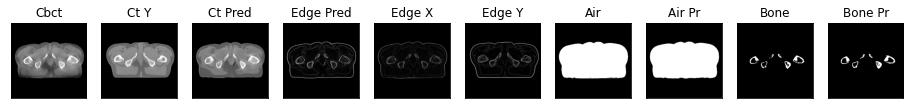

60it [00:23,  2.72it/s]

ssim score = 0.7738034129142761
psnr score = 20.881671905517578
snr score = 11.229585647583008
mae error = 0.037412308156490326
air dice score = 0.993959889482543
bone dice score = 0.9023907963346685
contour dice score = 0.5341812372207642


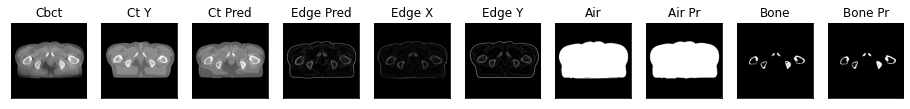

61it [00:23,  2.74it/s]

ssim score = 0.772682785987854
psnr score = 20.879852294921875
snr score = 11.221261024475098
mae error = 0.03733952343463898
air dice score = 0.993375756311293
bone dice score = 0.8992845349495636
contour dice score = 0.5387884974479675


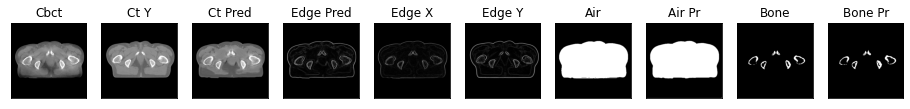

62it [00:24,  2.33it/s]

ssim score = 0.7718432545661926
psnr score = 20.800474166870117
snr score = 11.15599250793457
mae error = 0.03783004358410835
air dice score = 0.9944775292569814
bone dice score = 0.9012676307819806
contour dice score = 0.5432360768318176


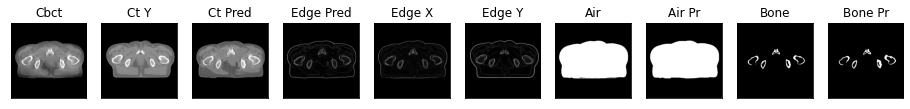

63it [00:24,  2.44it/s]

ssim score = 0.7704966068267822
psnr score = 20.71966552734375
snr score = 11.133193969726562
mae error = 0.03907061368227005
air dice score = 0.994632531526319
bone dice score = 0.8927065438092658
contour dice score = 0.568993091583252


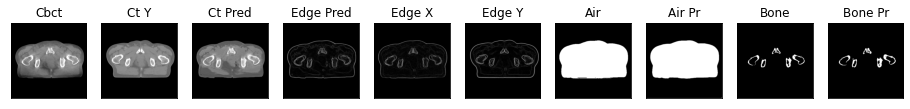

64it [00:25,  2.53it/s]

ssim score = 0.7654625773429871
psnr score = 20.503177642822266
snr score = 11.015263557434082
mae error = 0.04122850298881531
air dice score = 0.9943338134211914
bone dice score = 0.8753414809507499
contour dice score = 0.5635883808135986


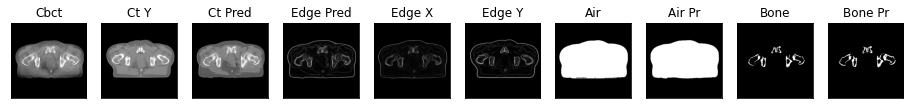

65it [00:25,  2.59it/s]

ssim score = 0.7521452903747559
psnr score = 20.19162368774414
snr score = 10.739537239074707
mae error = 0.0437660776078701
air dice score = 0.9947420506862917
bone dice score = 0.8683381285125588
contour dice score = 0.5214592218399048


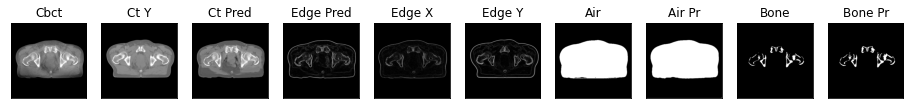

66it [00:25,  2.64it/s]

ssim score = 0.7442668676376343
psnr score = 20.01096534729004
snr score = 10.591588020324707
mae error = 0.04484651982784271
air dice score = 0.9951444212407979
bone dice score = 0.8415853809131796
contour dice score = 0.5543071031570435


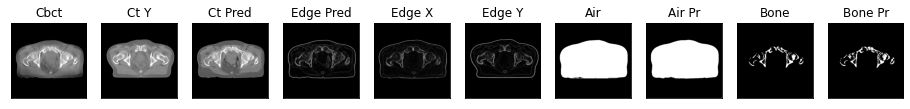

67it [00:26,  2.67it/s]

ssim score = 0.743044912815094
psnr score = 20.146224975585938
snr score = 10.84366226196289
mae error = 0.04413165524601936
air dice score = 0.9954554435882276
bone dice score = 0.8505247918946732
contour dice score = 0.5887309312820435


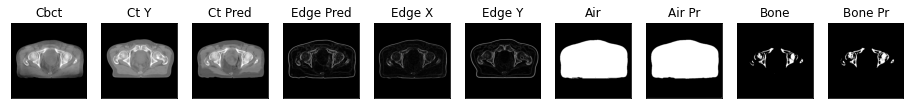

68it [00:26,  2.70it/s]

ssim score = 0.7479223012924194
psnr score = 20.219820022583008
snr score = 10.901270866394043
mae error = 0.04272550716996193
air dice score = 0.9960489246203565
bone dice score = 0.8553658859354855
contour dice score = 0.5804347991943359


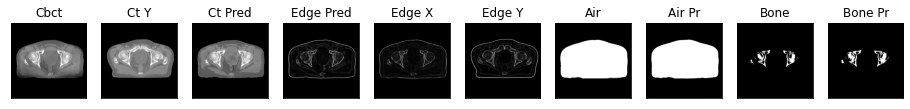

69it [00:26,  2.71it/s]

ssim score = 0.7626566290855408
psnr score = 20.803125381469727
snr score = 11.28541374206543
mae error = 0.03863592445850372
air dice score = 0.9957026324592816
bone dice score = 0.8706524863485103
contour dice score = 0.5702036619186401


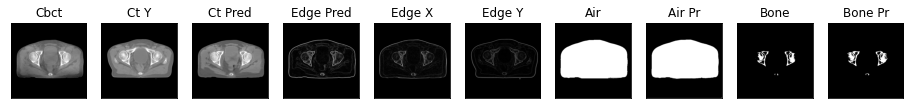

70it [00:27,  2.73it/s]

ssim score = 0.7728501558303833
psnr score = 21.488265991210938
snr score = 11.800161361694336
mae error = 0.035424429923295975
air dice score = 0.9953498728280178
bone dice score = 0.9062844542460545
contour dice score = 0.5738850235939026


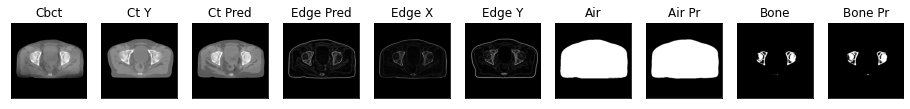

71it [00:27,  2.74it/s]

ssim score = 0.7756538391113281
psnr score = 21.879234313964844
snr score = 12.205299377441406
mae error = 0.033636439591646194
air dice score = 0.9948160863587108
bone dice score = 0.9247254927910474
contour dice score = 0.5746268630027771


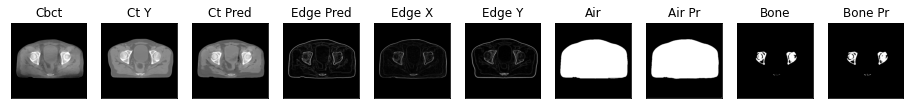

72it [00:28,  2.33it/s]

ssim score = 0.7815482020378113
psnr score = 22.032913208007812
snr score = 12.440807342529297
mae error = 0.033095911145210266
air dice score = 0.9955768427691217
bone dice score = 0.9316958741557652
contour dice score = 0.6157181859016418


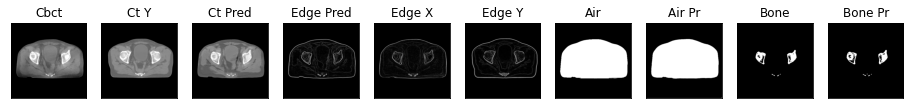

73it [00:28,  2.44it/s]

ssim score = 0.7815971374511719
psnr score = 21.990673065185547
snr score = 12.490738868713379
mae error = 0.03348442167043686
air dice score = 0.9958265688616174
bone dice score = 0.918634381111165
contour dice score = 0.5919824242591858


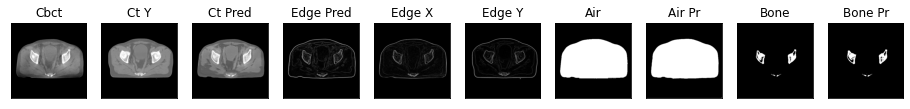

74it [00:28,  2.53it/s]

ssim score = 0.7800692915916443
psnr score = 22.236400604248047
snr score = 12.673038482666016
mae error = 0.03288772702217102
air dice score = 0.995747132279439
bone dice score = 0.9366880447305265
contour dice score = 0.6020353436470032


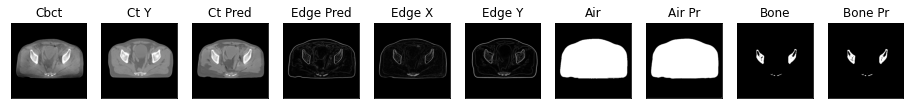

75it [00:29,  2.59it/s]

ssim score = 0.7869910001754761
psnr score = 22.590961456298828
snr score = 12.991205215454102
mae error = 0.03143535181879997
air dice score = 0.9948307515292051
bone dice score = 0.9276701617215627
contour dice score = 0.5329787135124207


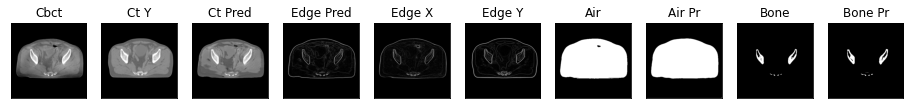

76it [00:29,  2.64it/s]

ssim score = 0.7826838493347168
psnr score = 22.229576110839844
snr score = 12.667566299438477
mae error = 0.03366629406809807
air dice score = 0.9944326931212502
bone dice score = 0.9071861188425735
contour dice score = 0.5574986934661865


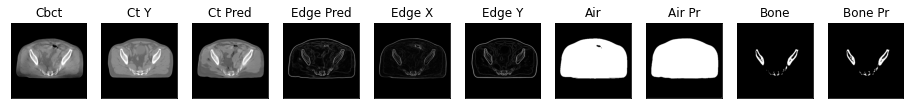

77it [00:29,  2.68it/s]

ssim score = 0.7801677584648132
psnr score = 21.917211532592773
snr score = 12.485705375671387
mae error = 0.035361334681510925
air dice score = 0.9947489667321678
bone dice score = 0.9047619047632626
contour dice score = 0.5403096675872803


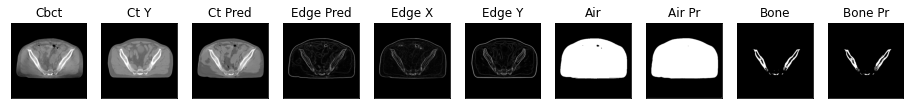

78it [00:30,  2.70it/s]

ssim score = 0.7838603258132935
psnr score = 21.81938362121582
snr score = 12.40562629699707
mae error = 0.035522785037755966
air dice score = 0.9949048595221329
bone dice score = 0.8796031865342011
contour dice score = 0.5429184436798096


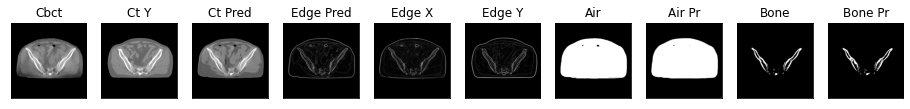

79it [00:30,  2.71it/s]

ssim score = 0.7853008508682251
psnr score = 22.115304946899414
snr score = 12.690279006958008
mae error = 0.03499376028776169
air dice score = 0.9952567751198667
bone dice score = 0.8849761395444302
contour dice score = 0.48625338077545166


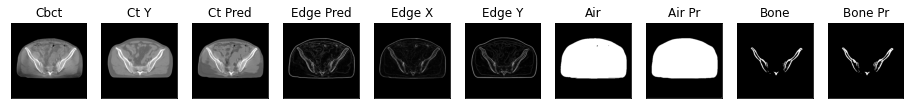

80it [00:31,  2.72it/s]

ssim score = 0.7900557518005371
psnr score = 22.212669372558594
snr score = 12.786903381347656
mae error = 0.03433575853705406
air dice score = 0.9957095539652339
bone dice score = 0.870288944725655
contour dice score = 0.519565224647522


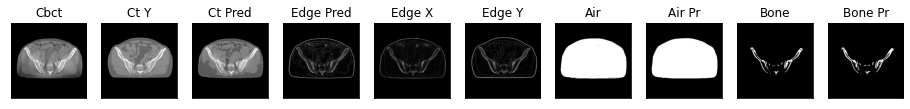

81it [00:31,  2.74it/s]

ssim score = 0.8488178849220276
psnr score = 23.948781967163086
snr score = 14.382915496826172
mae error = 0.02416509948670864
air dice score = 0.9926457200307213
bone dice score = 0.9149623250837832
contour dice score = 0.5254777073860168


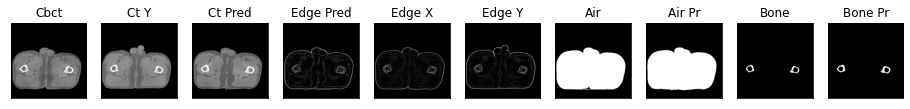

82it [00:32,  2.34it/s]

ssim score = 0.8492050170898438
psnr score = 24.049957275390625
snr score = 14.548484802246094
mae error = 0.024528415873646736
air dice score = 0.9937602420269809
bone dice score = 0.8869621066189158
contour dice score = 0.5028690695762634


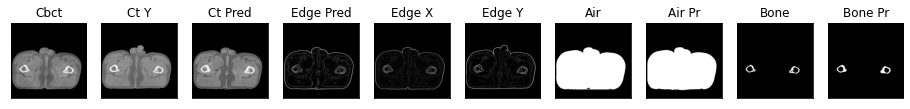

83it [00:32,  2.45it/s]

ssim score = 0.8494113683700562
psnr score = 25.019119262695312
snr score = 15.65685749053955
mae error = 0.024729222059249878
air dice score = 0.9949016978749319
bone dice score = 0.9144466103548962
contour dice score = 0.5078401565551758


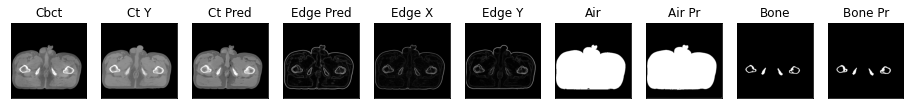

84it [00:32,  2.53it/s]

ssim score = 0.8485927581787109
psnr score = 24.782806396484375
snr score = 15.542037963867188
mae error = 0.0261270422488451
air dice score = 0.9954352078998886
bone dice score = 0.883569979718386
contour dice score = 0.5482388734817505


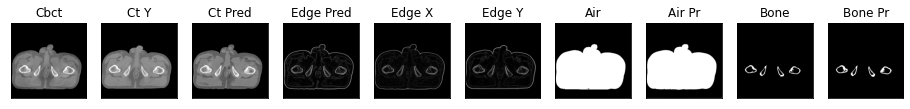

85it [00:33,  2.59it/s]

ssim score = 0.8430938720703125
psnr score = 24.537277221679688
snr score = 15.3206787109375
mae error = 0.02708868682384491
air dice score = 0.995808313640417
bone dice score = 0.8738144329922924
contour dice score = 0.5323666334152222


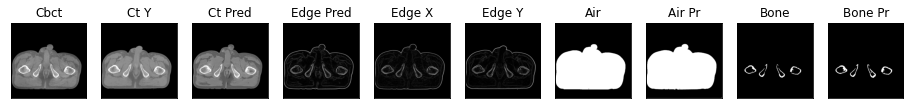

86it [00:33,  2.64it/s]

ssim score = 0.8424969911575317
psnr score = 24.414363861083984
snr score = 15.193367958068848
mae error = 0.027316633611917496
air dice score = 0.9958280765033276
bone dice score = 0.8699905926647227
contour dice score = 0.49660927057266235


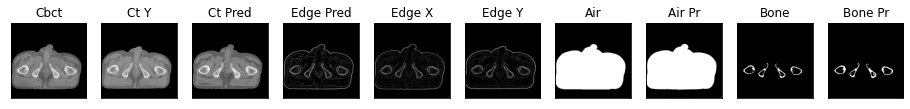

87it [00:33,  2.67it/s]

ssim score = 0.843492865562439
psnr score = 24.207277297973633
snr score = 14.992538452148438
mae error = 0.02771434187889099
air dice score = 0.9957933157023804
bone dice score = 0.8787541713036938
contour dice score = 0.49290594458580017


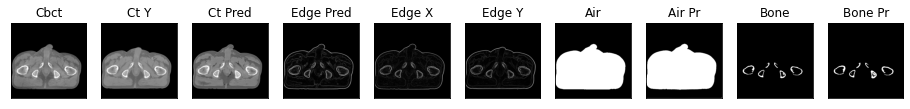

88it [00:34,  2.70it/s]

ssim score = 0.8431243300437927
psnr score = 24.140642166137695
snr score = 14.904346466064453
mae error = 0.0272543765604496
air dice score = 0.9959584385016832
bone dice score = 0.881221719459253
contour dice score = 0.5296899676322937


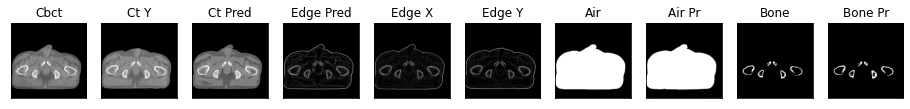

89it [00:34,  2.70it/s]

ssim score = 0.8412424325942993
psnr score = 24.096860885620117
snr score = 14.877476692199707
mae error = 0.02756079100072384
air dice score = 0.9959228684367921
bone dice score = 0.9031680687327158
contour dice score = 0.536791980266571


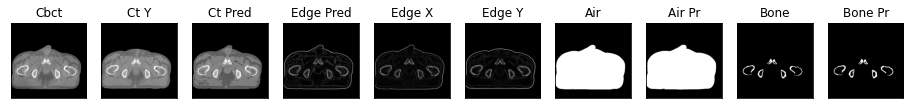

90it [00:34,  2.72it/s]

ssim score = 0.8413199186325073
psnr score = 24.162874221801758
snr score = 15.012084007263184
mae error = 0.028332743793725967
air dice score = 0.9960872344073983
bone dice score = 0.902649114254792
contour dice score = 0.583155632019043


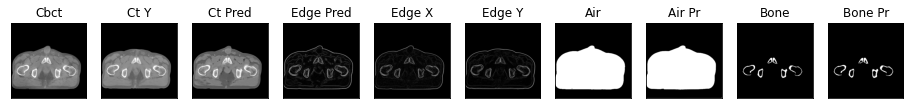

91it [00:35,  2.72it/s]

ssim score = 0.8384647369384766
psnr score = 23.918800354003906
snr score = 14.849369049072266
mae error = 0.030010925605893135
air dice score = 0.9960332052796739
bone dice score = 0.9041381363515312
contour dice score = 0.5568669438362122


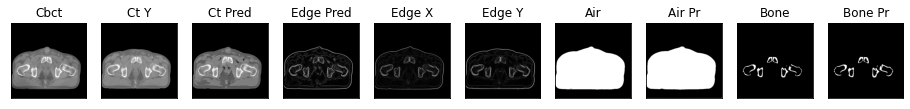

92it [00:35,  2.34it/s]

ssim score = 0.8378063440322876
psnr score = 23.841936111450195
snr score = 14.823205947875977
mae error = 0.031141838058829308
air dice score = 0.9965038536175322
bone dice score = 0.8824370709398965
contour dice score = 0.5692803263664246


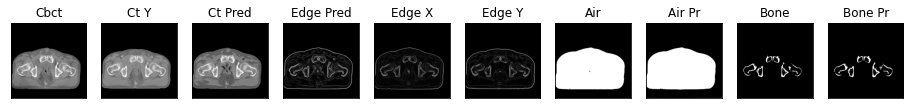

93it [00:36,  2.45it/s]

ssim score = 0.8354998826980591
psnr score = 23.504087448120117
snr score = 14.601629257202148
mae error = 0.03259877860546112
air dice score = 0.9966422851377793
bone dice score = 0.8671938914662232
contour dice score = 0.5537634491920471


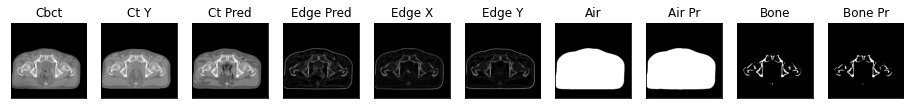

94it [00:36,  2.53it/s]

ssim score = 0.8353657722473145
psnr score = 23.387052536010742
snr score = 14.446357727050781
mae error = 0.0325700081884861
air dice score = 0.9964581996244294
bone dice score = 0.853447050464059
contour dice score = 0.5755782723426819


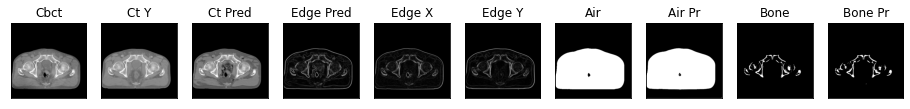

95it [00:36,  2.59it/s]

ssim score = 0.8340046405792236
psnr score = 23.35609245300293
snr score = 14.319725036621094
mae error = 0.031724244356155396
air dice score = 0.9954120754175048
bone dice score = 0.8621404508958002
contour dice score = 0.5342687368392944


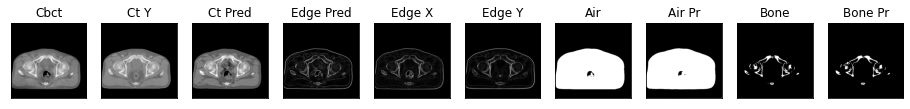

96it [00:37,  2.64it/s]

ssim score = 0.842007040977478
psnr score = 23.613994598388672
snr score = 14.417868614196777
mae error = 0.02951367013156414
air dice score = 0.9935483870967794
bone dice score = 0.85902543671684
contour dice score = 0.5073012709617615


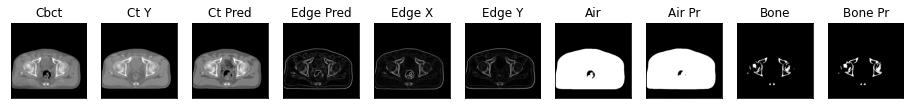

97it [00:37,  2.68it/s]

ssim score = 0.8453657627105713
psnr score = 23.414588928222656
snr score = 14.102038383483887
mae error = 0.029047628864645958
air dice score = 0.993671091493303
bone dice score = 0.8470189493167922
contour dice score = 0.48642778396606445


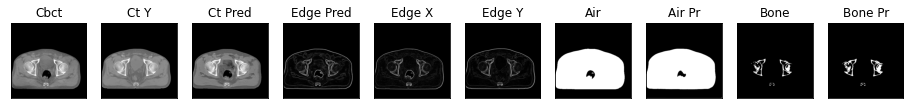

98it [00:38,  2.71it/s]

ssim score = 0.8423277139663696
psnr score = 23.448026657104492
snr score = 14.09037971496582
mae error = 0.02888328582048416
air dice score = 0.9944183385772121
bone dice score = 0.8712813815139852
contour dice score = 0.516866147518158


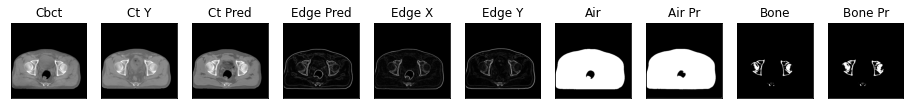

99it [00:38,  2.71it/s]

ssim score = 0.8393968343734741
psnr score = 23.120079040527344
snr score = 13.7691068649292
mae error = 0.029598934575915337
air dice score = 0.9949216958259658
bone dice score = 0.8941211757664349
contour dice score = 0.5059978365898132


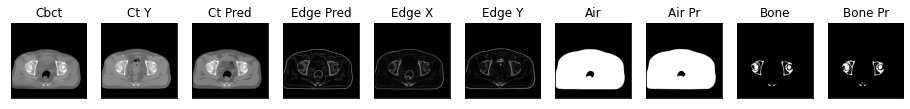

100it [00:38,  2.72it/s]

ssim score = 0.8401657938957214
psnr score = 22.860633850097656
snr score = 13.539764404296875
mae error = 0.03036830574274063
air dice score = 0.9951250738625212
bone dice score = 0.9259259259270146
contour dice score = 0.5355191230773926


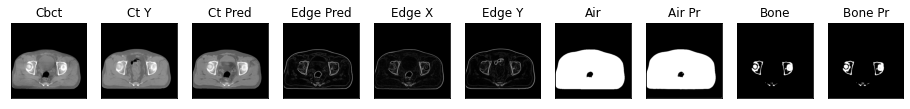

101it [00:39,  2.74it/s]

ssim score = 0.8476704955101013
psnr score = 23.50604248046875
snr score = 14.142587661743164
mae error = 0.0285508893430233
air dice score = 0.9944631009910767
bone dice score = 0.9156826875117964
contour dice score = 0.5166940093040466


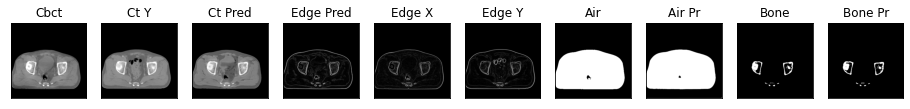

102it [00:39,  2.34it/s]

ssim score = 0.8520891070365906
psnr score = 23.780391693115234
snr score = 14.326732635498047
mae error = 0.02697722427546978
air dice score = 0.9950776221128401
bone dice score = 0.9173353237559744
contour dice score = 0.5336249470710754


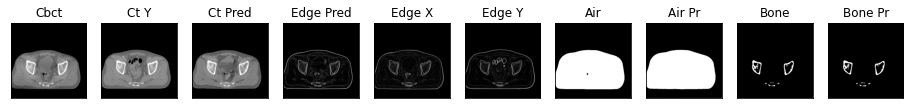

103it [00:40,  2.46it/s]

ssim score = 0.8549789786338806
psnr score = 23.798646926879883
snr score = 14.279261589050293
mae error = 0.026423009112477303
air dice score = 0.9933614164527254
bone dice score = 0.9175654853636832
contour dice score = 0.5482456088066101


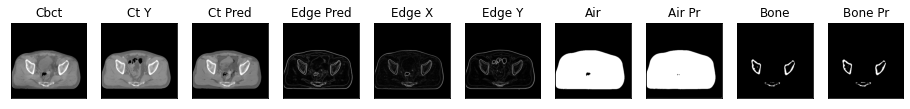

104it [00:40,  2.54it/s]

ssim score = 0.8524096608161926
psnr score = 23.728225708007812
snr score = 14.208538055419922
mae error = 0.026823697611689568
air dice score = 0.9934598926451063
bone dice score = 0.9259449290246974
contour dice score = 0.5508521199226379


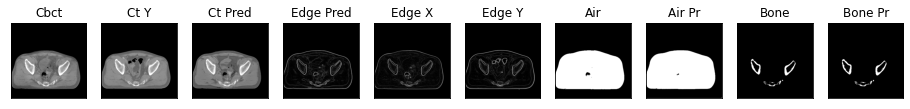

105it [00:40,  2.59it/s]

ssim score = 0.8465492129325867
psnr score = 23.747350692749023
snr score = 14.303831100463867
mae error = 0.02804669737815857
air dice score = 0.992072403691109
bone dice score = 0.9171956552416816
contour dice score = 0.5275937914848328


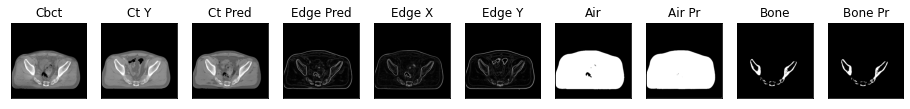

106it [00:41,  2.65it/s]

ssim score = 0.8483220338821411
psnr score = 23.807125091552734
snr score = 14.399186134338379
mae error = 0.02792458049952984
air dice score = 0.9930257875757017
bone dice score = 0.9017525225716708
contour dice score = 0.5121412873268127


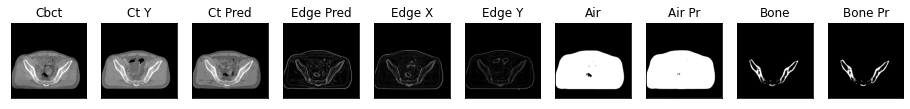

107it [00:41,  2.68it/s]

ssim score = 0.8467723727226257
psnr score = 24.241418838500977
snr score = 14.771781921386719
mae error = 0.02707010507583618
air dice score = 0.9943406080635682
bone dice score = 0.8757197022907496
contour dice score = 0.5232815742492676


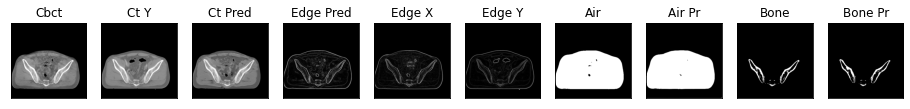

108it [00:41,  2.70it/s]

ssim score = 0.8431534767150879
psnr score = 23.970752716064453
snr score = 14.43985366821289
mae error = 0.02756667323410511
air dice score = 0.9945871282427637
bone dice score = 0.8816267247656989
contour dice score = 0.49413079023361206


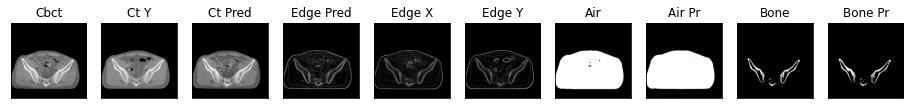

109it [00:42,  2.72it/s]

ssim score = 0.7468726634979248
psnr score = 21.600744247436523
snr score = 13.298051834106445
mae error = 0.03744365647435188
air dice score = 0.9961404588828664
bone dice score = 0.9504029758229882
contour dice score = 0.5870427489280701


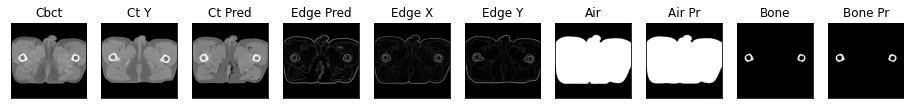

110it [00:42,  2.73it/s]

ssim score = 0.7402451634407043
psnr score = 21.179105758666992
snr score = 12.980703353881836
mae error = 0.040084753185510635
air dice score = 0.9963985594237716
bone dice score = 0.9406544647825664
contour dice score = 0.5619174242019653


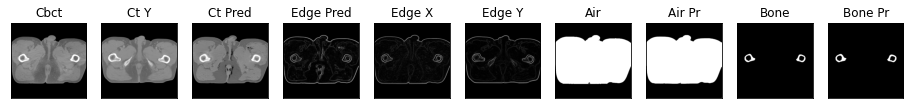

111it [00:42,  2.73it/s]

ssim score = 0.7289224863052368
psnr score = 20.486974716186523
snr score = 12.41653060913086
mae error = 0.044591981917619705
air dice score = 0.9968905837489018
bone dice score = 0.923248053394366
contour dice score = 0.5571428537368774


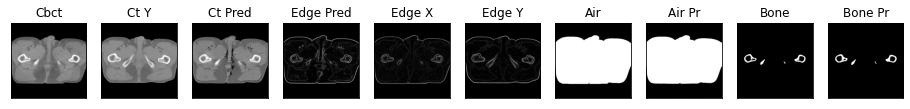

112it [00:43,  2.34it/s]

ssim score = 0.7244658470153809
psnr score = 20.347549438476562
snr score = 12.309393882751465
mae error = 0.04587280750274658
air dice score = 0.9969798775562779
bone dice score = 0.9250172771263818
contour dice score = 0.4997756779193878


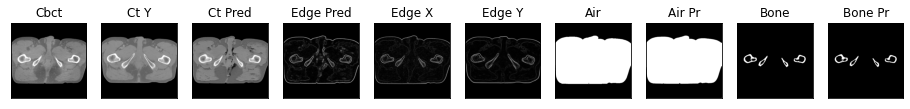

113it [00:43,  2.45it/s]

ssim score = 0.7085837125778198
psnr score = 20.19498634338379
snr score = 12.187066078186035
mae error = 0.048062488436698914
air dice score = 0.9969516468114944
bone dice score = 0.9030333167594392
contour dice score = 0.47297295928001404


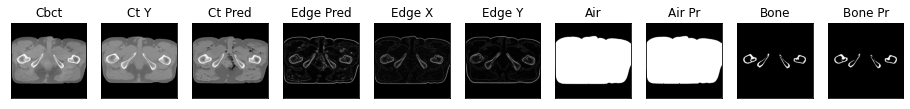

114it [00:44,  2.53it/s]

ssim score = 0.7057574391365051
psnr score = 20.04198455810547
snr score = 12.068485260009766
mae error = 0.04911722615361214
air dice score = 0.9968154905716416
bone dice score = 0.9088895919027382
contour dice score = 0.4837545156478882


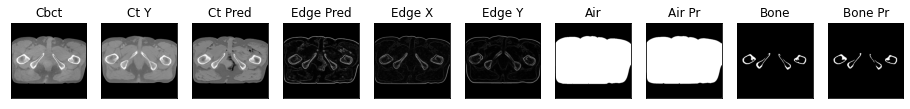

115it [00:44,  2.59it/s]

ssim score = 0.6883082985877991
psnr score = 19.60872459411621
snr score = 11.655532836914062
mae error = 0.05133333429694176
air dice score = 0.9969895067779619
bone dice score = 0.9011891279742187
contour dice score = 0.47117117047309875


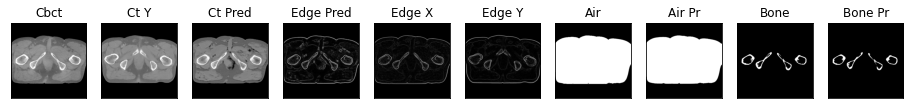

116it [00:44,  2.63it/s]

ssim score = 0.6922966241836548
psnr score = 19.64543342590332
snr score = 11.731315612792969
mae error = 0.05094270408153534
air dice score = 0.9961298246833779
bone dice score = 0.8920616790420893
contour dice score = 0.48186296224594116


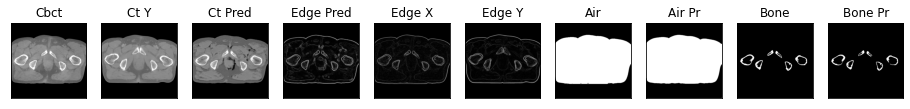

117it [00:45,  2.66it/s]

ssim score = 0.6851999163627625
psnr score = 19.625375747680664
snr score = 11.75993824005127
mae error = 0.05220402404665947
air dice score = 0.9954863344284358
bone dice score = 0.9022846132686171
contour dice score = 0.46287450194358826


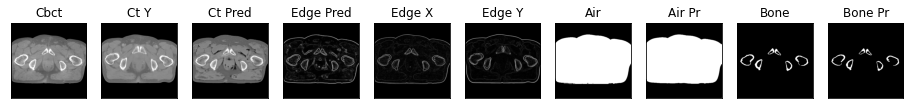

118it [00:45,  2.69it/s]

ssim score = 0.6776124238967896
psnr score = 19.32693862915039
snr score = 11.484111785888672
mae error = 0.05461297184228897
air dice score = 0.9955811407953972
bone dice score = 0.89321169841839
contour dice score = 0.4516128897666931


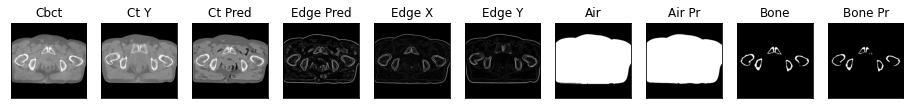

119it [00:46,  2.70it/s]

ssim score = 0.6584130525588989
psnr score = 19.02918815612793
snr score = 11.229138374328613
mae error = 0.05841844156384468
air dice score = 0.9963604432171392
bone dice score = 0.8812877263596417
contour dice score = 0.4464285671710968


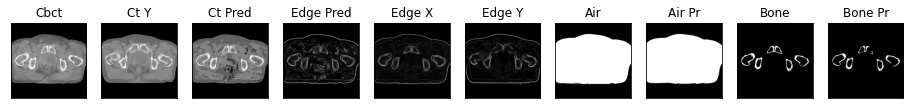

120it [00:46,  2.69it/s]

ssim score = 0.6577306985855103
psnr score = 18.90726661682129
snr score = 11.165555953979492
mae error = 0.05978389084339142
air dice score = 0.9961583873290158
bone dice score = 0.8838694957804714
contour dice score = 0.45923912525177


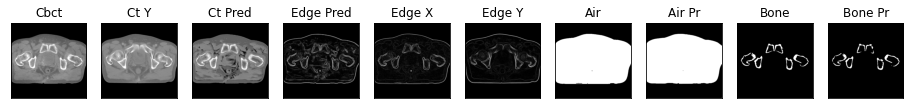

121it [00:46,  2.70it/s]

ssim score = 0.6497343182563782
psnr score = 18.499765396118164
snr score = 10.682682991027832
mae error = 0.06354409456253052
air dice score = 0.9965526171908742
bone dice score = 0.8436018957362816
contour dice score = 0.4331965446472168


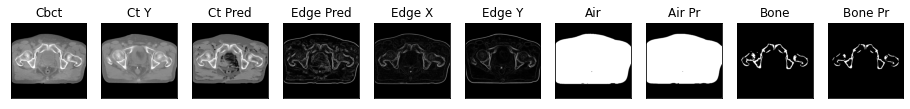

122it [00:47,  2.30it/s]

ssim score = 0.6557391285896301
psnr score = 18.72829818725586
snr score = 10.803998947143555
mae error = 0.061527542769908905
air dice score = 0.9964496769033377
bone dice score = 0.8201730954180982
contour dice score = 0.4223034679889679


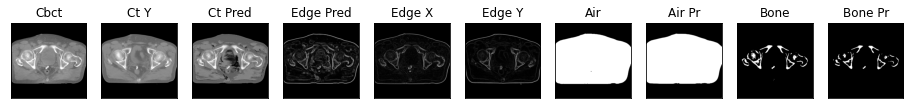

123it [00:47,  2.42it/s]

ssim score = 0.6638245582580566
psnr score = 19.210777282714844
snr score = 11.1633882522583
mae error = 0.05643080919981003
air dice score = 0.9968153416453127
bone dice score = 0.7705532290084796
contour dice score = 0.4486238658428192


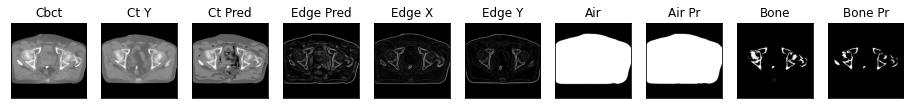

124it [00:48,  2.50it/s]

ssim score = 0.6735578179359436
psnr score = 19.235816955566406
snr score = 11.075996398925781
mae error = 0.05518283322453499
air dice score = 0.9973630609265653
bone dice score = 0.8526964227833924
contour dice score = 0.4702627956867218


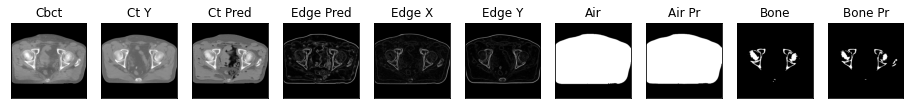

125it [00:48,  2.56it/s]

ssim score = 0.671798050403595
psnr score = 19.605377197265625
snr score = 11.39491081237793
mae error = 0.05215524137020111
air dice score = 0.9972638873624006
bone dice score = 0.8959439371427486
contour dice score = 0.4946734607219696


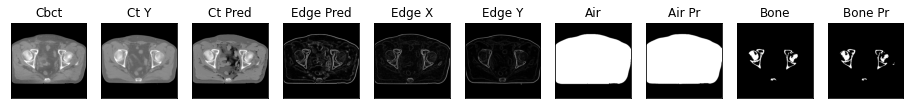

126it [00:48,  2.60it/s]

ssim score = 0.6795256733894348
psnr score = 19.586021423339844
snr score = 11.407710075378418
mae error = 0.05111720785498619
air dice score = 0.997196277957406
bone dice score = 0.8999547306484839
contour dice score = 0.5009293556213379


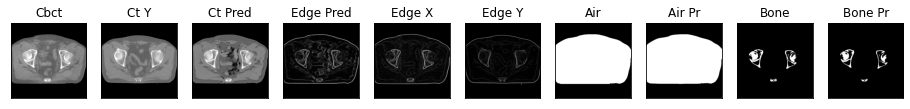

127it [00:49,  2.65it/s]

ssim score = 0.6772252917289734
psnr score = 19.472145080566406
snr score = 11.30731201171875
mae error = 0.05226917937397957
air dice score = 0.997208445762842
bone dice score = 0.8918655625926465
contour dice score = 0.49626168608665466


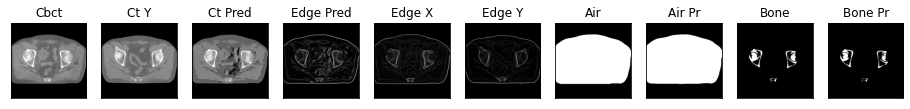

128it [00:49,  2.68it/s]

ssim score = 0.6758960485458374
psnr score = 19.45580291748047
snr score = 11.1494779586792
mae error = 0.05270407721400261
air dice score = 0.9971592739455651
bone dice score = 0.8954160009844486
contour dice score = 0.46820536255836487


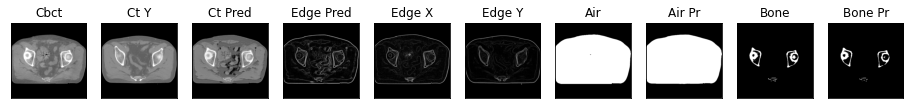

129it [00:49,  2.70it/s]

ssim score = 0.6912612915039062
psnr score = 19.67563819885254
snr score = 11.310004234313965
mae error = 0.05102378502488136
air dice score = 0.9969857884635781
bone dice score = 0.918233737290455
contour dice score = 0.479432612657547


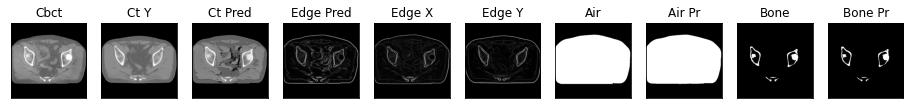

130it [00:50,  2.72it/s]

ssim score = 0.6900631785392761
psnr score = 19.867822647094727
snr score = 11.527835845947266
mae error = 0.049089688807725906
air dice score = 0.9968283648327217
bone dice score = 0.903583302550728
contour dice score = 0.49456265568733215


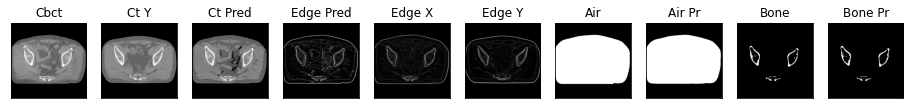

131it [00:50,  2.72it/s]

ssim score = 0.6832283139228821
psnr score = 19.68398094177246
snr score = 11.416808128356934
mae error = 0.050193432718515396
air dice score = 0.996450126356476
bone dice score = 0.9095966620321697
contour dice score = 0.477993369102478


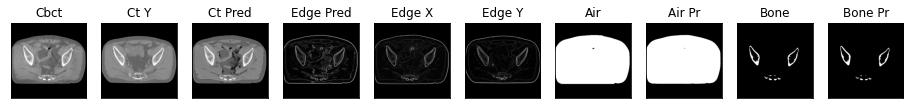

132it [00:51,  2.32it/s]

ssim score = 0.682628870010376
psnr score = 19.415613174438477
snr score = 11.277670860290527
mae error = 0.05207463353872299
air dice score = 0.9962631909359981
bone dice score = 0.9192263936304368
contour dice score = 0.48427072167396545


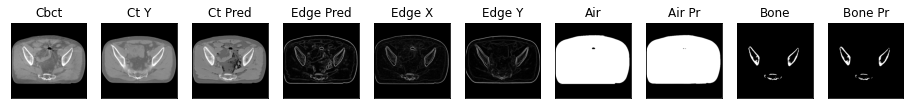

133it [00:51,  2.43it/s]

ssim score = 0.6776623725891113
psnr score = 19.23402976989746
snr score = 11.130047798156738
mae error = 0.05360396206378937
air dice score = 0.9964504445968568
bone dice score = 0.9025052822230228
contour dice score = 0.48633092641830444


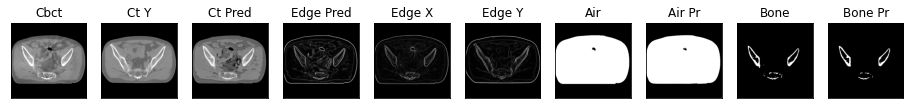

134it [00:52,  2.52it/s]

ssim score = 0.6634877324104309
psnr score = 18.962942123413086
snr score = 10.829170227050781
mae error = 0.05556787922978401
air dice score = 0.9966207246131957
bone dice score = 0.8876620875608209
contour dice score = 0.4607984721660614


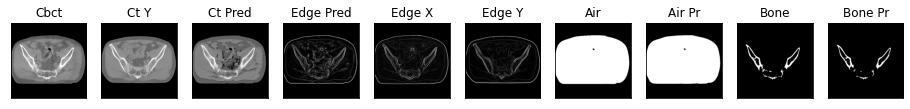

135it [00:52,  2.58it/s]

ssim score = 0.6638231873512268
psnr score = 19.300376892089844
snr score = 11.103229522705078
mae error = 0.05351264774799347
air dice score = 0.996681523108228
bone dice score = 0.8686341798233543
contour dice score = 0.46837276220321655


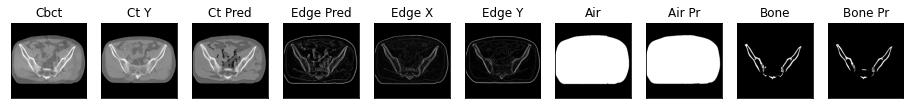

136it [00:52,  2.61it/s]

ssim score = 0.7826833128929138
psnr score = 21.615886688232422
snr score = 13.093278884887695
mae error = 0.040617991238832474
air dice score = 0.9955982333750116
bone dice score = 0.8949293027804127
contour dice score = 0.5662650465965271


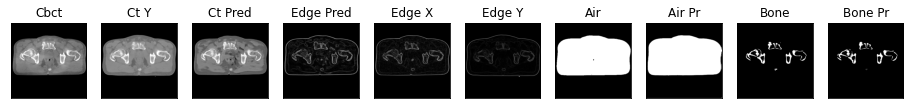

137it [00:53,  2.66it/s]

ssim score = 0.7845303416252136
psnr score = 21.614402770996094
snr score = 13.131807327270508
mae error = 0.040474552661180496
air dice score = 0.9955685321318506
bone dice score = 0.8834216502664216
contour dice score = 0.5433467626571655


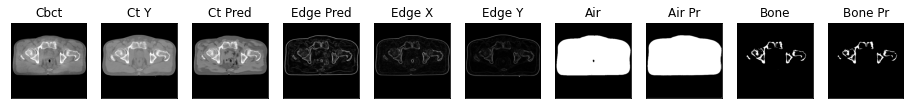

138it [00:53,  2.69it/s]

ssim score = 0.782842218875885
psnr score = 21.530895233154297
snr score = 13.056085586547852
mae error = 0.041133321821689606
air dice score = 0.9958970478034769
bone dice score = 0.8730964467021594
contour dice score = 0.5321193933486938


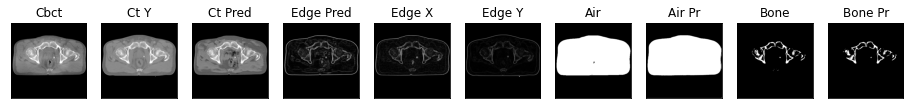

139it [00:53,  2.71it/s]

ssim score = 0.7910572290420532
psnr score = 21.740570068359375
snr score = 13.2073392868042
mae error = 0.03990624099969864
air dice score = 0.9951345801901568
bone dice score = 0.8763336566455342
contour dice score = 0.5098834037780762


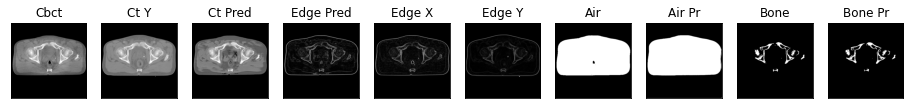

140it [00:54,  2.73it/s]

ssim score = 0.7983748912811279
psnr score = 21.950653076171875
snr score = 13.261798858642578
mae error = 0.03753010183572769
air dice score = 0.994844245476594
bone dice score = 0.8677026459489332
contour dice score = 0.49694502353668213


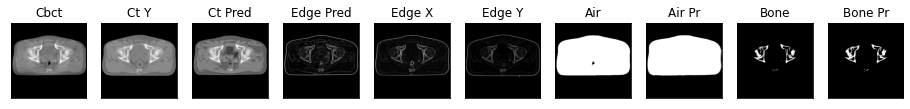

141it [00:54,  2.73it/s]

ssim score = 0.804392397403717
psnr score = 22.248342514038086
snr score = 13.538684844970703
mae error = 0.03619317337870598
air dice score = 0.9951133361770311
bone dice score = 0.8880827623285223
contour dice score = 0.46350178122520447


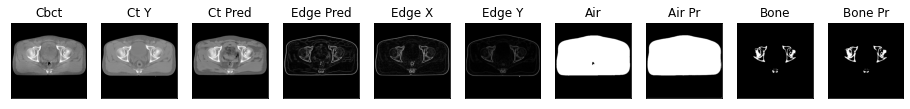

142it [00:55,  2.34it/s]

ssim score = 0.8006150126457214
psnr score = 22.37356948852539
snr score = 13.648282051086426
mae error = 0.03568315505981445
air dice score = 0.99530805438153
bone dice score = 0.9025834230368328
contour dice score = 0.5279343724250793


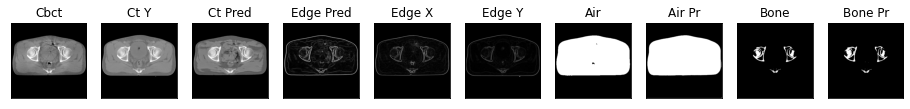

143it [00:55,  2.45it/s]

ssim score = 0.7946114540100098
psnr score = 22.140180587768555
snr score = 13.42425537109375
mae error = 0.036360032856464386
air dice score = 0.9947536633902229
bone dice score = 0.8932119205312746
contour dice score = 0.5460154414176941


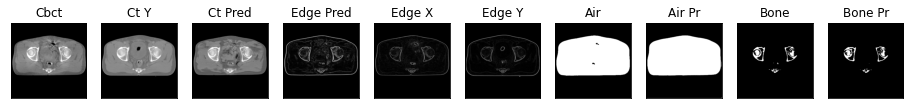

144it [00:55,  2.51it/s]

ssim score = 0.7884731888771057
psnr score = 21.831655502319336
snr score = 13.171512603759766
mae error = 0.03823588788509369
air dice score = 0.9952770661890872
bone dice score = 0.9235590679939562
contour dice score = 0.5113636255264282


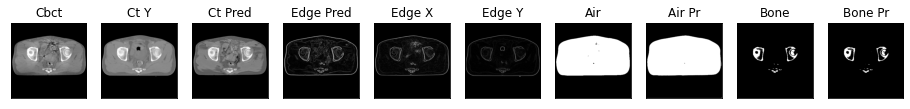

145it [00:56,  2.58it/s]

ssim score = 0.7887923121452332
psnr score = 21.5023136138916
snr score = 12.820240020751953
mae error = 0.03965918719768524
air dice score = 0.9945836873407008
bone dice score = 0.9165955024207715
contour dice score = 0.5002594590187073


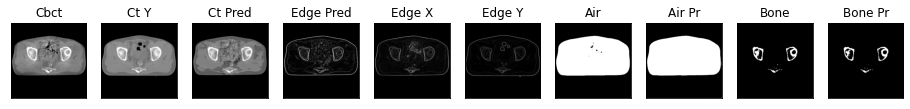

146it [00:56,  2.63it/s]

ssim score = 0.7917864918708801
psnr score = 21.374006271362305
snr score = 12.621163368225098
mae error = 0.03909646347165108
air dice score = 0.9943690266025489
bone dice score = 0.8853074636225112
contour dice score = 0.4846273958683014


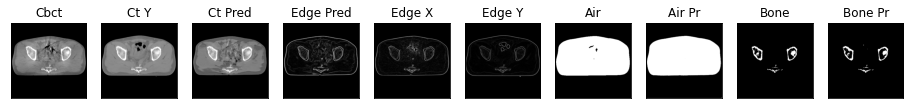

147it [00:56,  2.66it/s]

ssim score = 0.7942350506782532
psnr score = 21.731231689453125
snr score = 12.934493064880371
mae error = 0.03722924366593361
air dice score = 0.9951222486433792
bone dice score = 0.8988801604563116
contour dice score = 0.46572476625442505


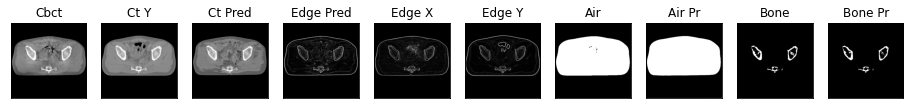

148it [00:57,  2.69it/s]

ssim score = 0.7998369932174683
psnr score = 22.08138656616211
snr score = 13.283550262451172
mae error = 0.03591301664710045
air dice score = 0.9948164345020606
bone dice score = 0.9005903941295581
contour dice score = 0.48975300788879395


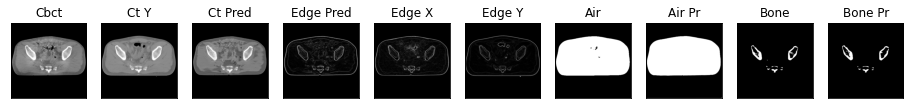

149it [00:57,  2.71it/s]

ssim score = 0.7951053977012634
psnr score = 22.01375961303711
snr score = 13.229280471801758
mae error = 0.03663686662912369
air dice score = 0.9942754535130036
bone dice score = 0.9221723657756123
contour dice score = 0.5023696422576904


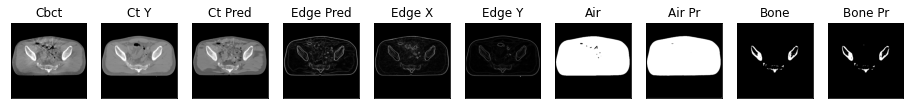

150it [00:58,  2.73it/s]

ssim score = 0.7885887026786804
psnr score = 21.845928192138672
snr score = 13.116653442382812
mae error = 0.03795754164457321
air dice score = 0.9933159815804521
bone dice score = 0.9118067281476581
contour dice score = 0.4831223487854004


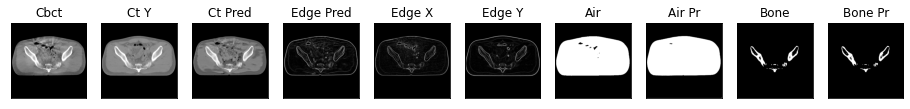

151it [00:58,  2.74it/s]

ssim score = 0.7935477495193481
psnr score = 21.54169464111328
snr score = 12.831789016723633
mae error = 0.0386575348675251
air dice score = 0.9937107888908658
bone dice score = 0.8978815860959005
contour dice score = 0.47780126333236694


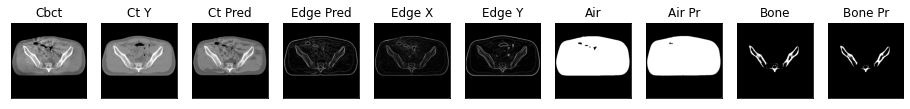

152it [00:58,  2.33it/s]

ssim score = 0.7999156713485718
psnr score = 21.56501007080078
snr score = 12.80036735534668
mae error = 0.03792007640004158
air dice score = 0.9947080954551465
bone dice score = 0.8830520909775047
contour dice score = 0.46659597754478455


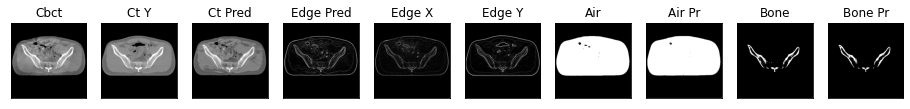

153it [00:59,  2.44it/s]

ssim score = 0.8031668066978455
psnr score = 21.780689239501953
snr score = 12.979692459106445
mae error = 0.03696354851126671
air dice score = 0.9950328695799994
bone dice score = 0.869756526842626
contour dice score = 0.47522643208503723


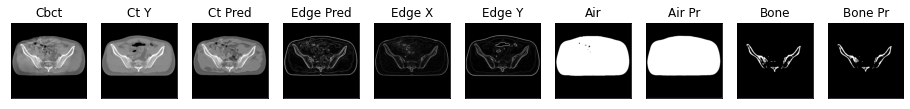

154it [00:59,  2.53it/s]

ssim score = 0.8029851913452148
psnr score = 21.874086380004883
snr score = 13.073162078857422
mae error = 0.036430008709430695
air dice score = 0.9952607367892108
bone dice score = 0.8625994694978435
contour dice score = 0.4855614900588989


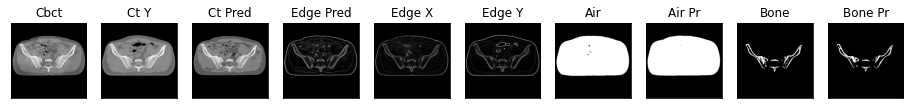

155it [01:00,  2.59it/s]

ssim score = 0.8020492196083069
psnr score = 22.067440032958984
snr score = 13.265092849731445
mae error = 0.03593418747186661
air dice score = 0.9951390178958487
bone dice score = 0.8642951251664783
contour dice score = 0.471030056476593


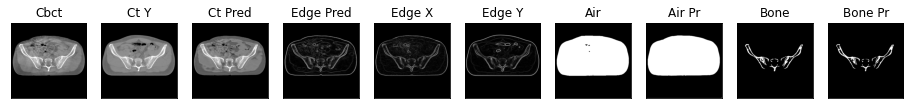

156it [01:00,  2.64it/s]

ssim score = 0.7956666350364685
psnr score = 21.76202392578125
snr score = 12.964716911315918
mae error = 0.03714170306921005
air dice score = 0.9947994287133671
bone dice score = 0.8653871608224304
contour dice score = 0.5175580978393555


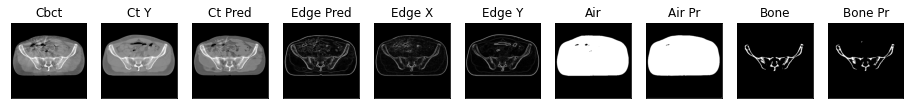

157it [01:00,  2.66it/s]

ssim score = 0.7898052930831909
psnr score = 21.3369140625
snr score = 12.522334098815918
mae error = 0.03892471268773079
air dice score = 0.9943297764623458
bone dice score = 0.8664288545400128
contour dice score = 0.4883088767528534


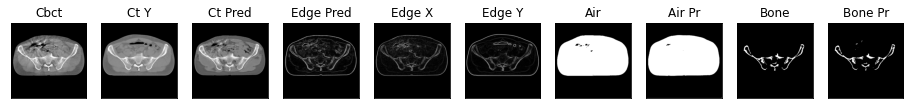

158it [01:01,  2.69it/s]

ssim score = 0.7861602306365967
psnr score = 21.00017738342285
snr score = 12.166975975036621
mae error = 0.03975415974855423
air dice score = 0.9947512105069699
bone dice score = 0.8350476190497137
contour dice score = 0.4821917712688446


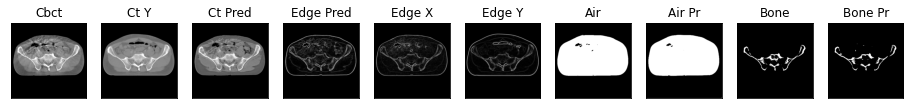

159it [01:01,  2.71it/s]

ssim score = 0.7774627208709717
psnr score = 20.68153190612793
snr score = 11.802388191223145
mae error = 0.04058196023106575
air dice score = 0.9943628797990152
bone dice score = 0.834179566565521
contour dice score = 0.4650137722492218


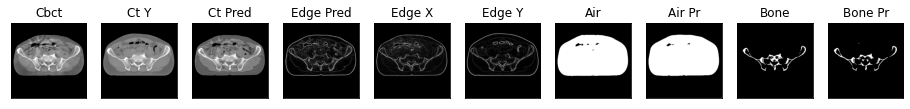

160it [01:01,  2.72it/s]

ssim score = 0.7733803987503052
psnr score = 20.793113708496094
snr score = 11.860174179077148
mae error = 0.0401456356048584
air dice score = 0.9943857435735732
bone dice score = 0.8746445497645183
contour dice score = 0.47502774000167847


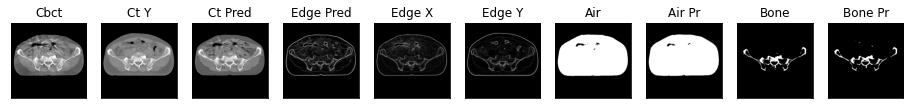

161it [01:02,  2.74it/s]

ssim score = 0.7620667815208435
psnr score = 20.270679473876953
snr score = 11.368204116821289
mae error = 0.042776353657245636
air dice score = 0.993068084702313
bone dice score = 0.8909599254439542
contour dice score = 0.4602557122707367


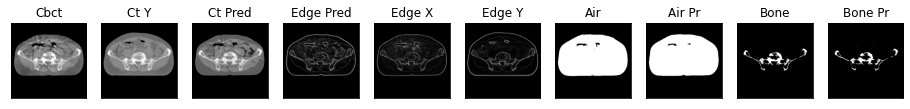

162it [01:02,  2.33it/s]

ssim score = 0.756205677986145
psnr score = 20.13023567199707
snr score = 11.172533988952637
mae error = 0.04224149137735367
air dice score = 0.9929579698651919
bone dice score = 0.8747392957934641
contour dice score = 0.5147303938865662


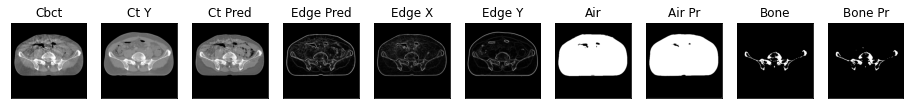

163it [01:03,  2.44it/s]

ssim score = 0.7625105977058411
psnr score = 20.83672523498535
snr score = 11.731492042541504
mae error = 0.03869042918086052
air dice score = 0.9935742142511111
bone dice score = 0.8794072560056284
contour dice score = 0.4628283977508545


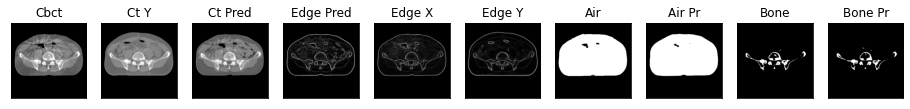

164it [01:03,  2.53it/s]

ssim score = 0.8141511678695679
psnr score = 24.472673416137695
snr score = 14.853586196899414
mae error = 0.023617761209607124
air dice score = 0.9942846200303488
bone dice score = 0.9003880983208179
contour dice score = 0.4658595621585846


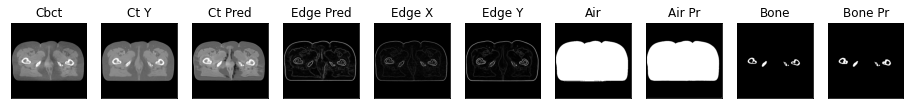

165it [01:03,  2.59it/s]

ssim score = 0.8159869909286499
psnr score = 24.509029388427734
snr score = 15.010953903198242
mae error = 0.023598816245794296
air dice score = 0.9943358117206293
bone dice score = 0.8948633879804402
contour dice score = 0.5101134777069092


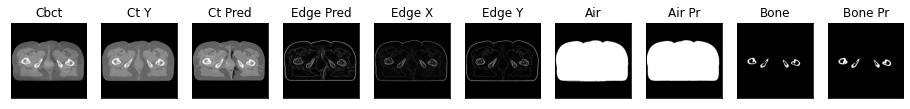

166it [01:04,  2.64it/s]

ssim score = 0.8159647583961487
psnr score = 24.59304428100586
snr score = 15.177885055541992
mae error = 0.023544691503047943
air dice score = 0.9939482106488261
bone dice score = 0.9012517385276922
contour dice score = 0.5043902397155762


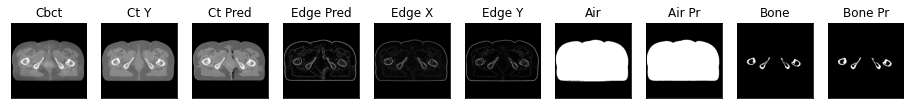

167it [01:04,  2.67it/s]

ssim score = 0.813128650188446
psnr score = 24.645919799804688
snr score = 15.294206619262695
mae error = 0.023353170603513718
air dice score = 0.9942241716246187
bone dice score = 0.8953960134080897
contour dice score = 0.5336585640907288


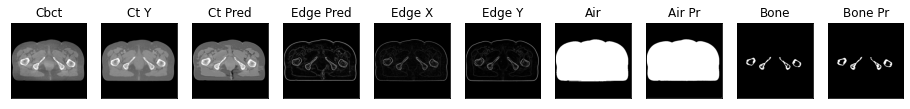

168it [01:05,  2.69it/s]

ssim score = 0.8105161786079407
psnr score = 24.472639083862305
snr score = 15.149385452270508
mae error = 0.02388676442205906
air dice score = 0.9943960823061929
bone dice score = 0.9110271384419267
contour dice score = 0.5206286907196045


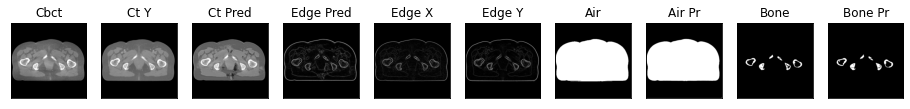

169it [01:05,  2.71it/s]

ssim score = 0.8147204518318176
psnr score = 24.48826789855957
snr score = 15.187969207763672
mae error = 0.023681869730353355
air dice score = 0.9942223149593877
bone dice score = 0.9122492836691932
contour dice score = 0.5136186480522156


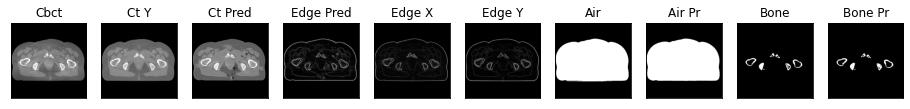

170it [01:05,  2.72it/s]

ssim score = 0.8109511733055115
psnr score = 24.312450408935547
snr score = 15.043478965759277
mae error = 0.02413814328610897
air dice score = 0.9942554322069235
bone dice score = 0.91604938271753
contour dice score = 0.512077271938324


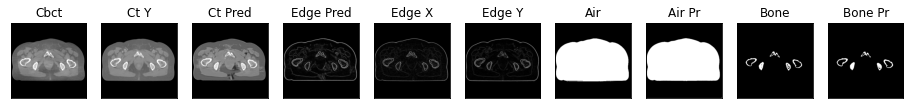

171it [01:06,  2.73it/s]

ssim score = 0.8077571988105774
psnr score = 24.027103424072266
snr score = 14.806498527526855
mae error = 0.02550625242292881
air dice score = 0.994270060167958
bone dice score = 0.9077027485594213
contour dice score = 0.5213715434074402


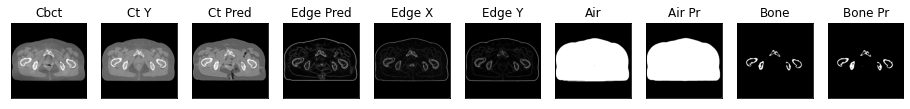

172it [01:06,  2.34it/s]

ssim score = 0.8081685304641724
psnr score = 23.87694549560547
snr score = 14.699085235595703
mae error = 0.025954170152544975
air dice score = 0.9935783498652646
bone dice score = 0.9107029765688616
contour dice score = 0.5249519944190979


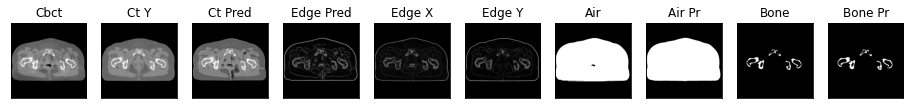

173it [01:07,  2.44it/s]

ssim score = 0.811336874961853
psnr score = 23.730680465698242
snr score = 14.640520095825195
mae error = 0.026634857058525085
air dice score = 0.9934003568536732
bone dice score = 0.9040043883721338
contour dice score = 0.5088702440261841


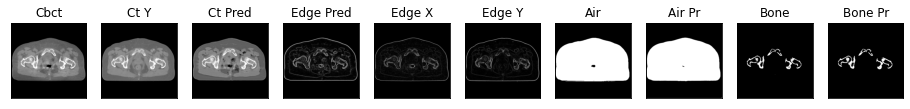

174it [01:07,  2.52it/s]

ssim score = 0.8114794492721558
psnr score = 24.1328125
snr score = 15.155924797058105
mae error = 0.026992661878466606
air dice score = 0.9941742582174414
bone dice score = 0.9018121520798079
contour dice score = 0.4935424327850342


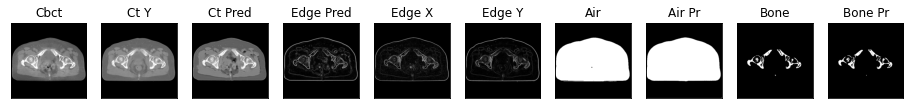

175it [01:07,  2.58it/s]

ssim score = 0.8144421577453613
psnr score = 24.235326766967773
snr score = 15.129890441894531
mae error = 0.025664983317255974
air dice score = 0.9925409390986307
bone dice score = 0.8579974811105479
contour dice score = 0.4642362594604492


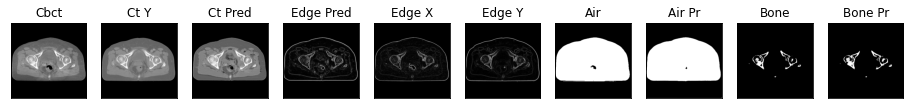

176it [01:08,  2.63it/s]

ssim score = 0.8192117810249329
psnr score = 24.469614028930664
snr score = 15.254751205444336
mae error = 0.02477487362921238
air dice score = 0.9919422180668518
bone dice score = 0.8464152225646209
contour dice score = 0.4481792747974396


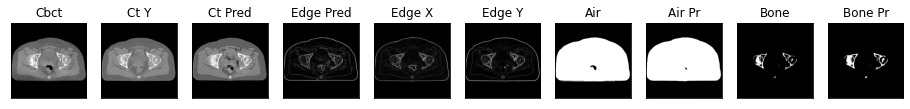

177it [01:08,  2.67it/s]

ssim score = 0.8226010799407959
psnr score = 24.240968704223633
snr score = 14.998979568481445
mae error = 0.02510189637541771
air dice score = 0.9932648905722755
bone dice score = 0.8924353654661278
contour dice score = 0.46083372831344604


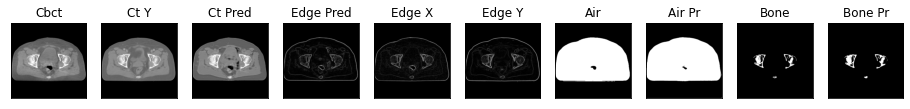

178it [01:08,  2.67it/s]

ssim score = 0.8240906596183777
psnr score = 24.64268684387207
snr score = 15.392693519592285
mae error = 0.02473672479391098
air dice score = 0.9943642475776192
bone dice score = 0.8973058637100269
contour dice score = 0.4675688147544861


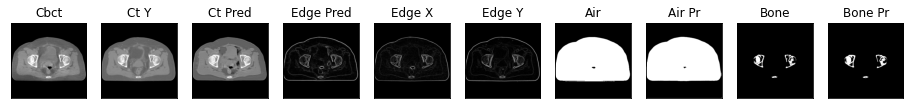

179it [01:09,  2.65it/s]

ssim score = 0.819365918636322
psnr score = 24.897348403930664
snr score = 15.681583404541016
mae error = 0.023822838440537453
air dice score = 0.994965373815746
bone dice score = 0.9180379250913957
contour dice score = 0.4459078013896942


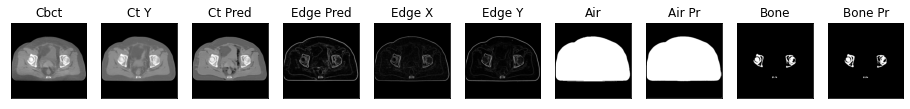

180it [01:09,  2.66it/s]

ssim score = 0.8116669058799744
psnr score = 24.36852264404297
snr score = 15.204249382019043
mae error = 0.024810904636979103
air dice score = 0.9954200807566976
bone dice score = 0.9363795018255374
contour dice score = 0.48003849387168884


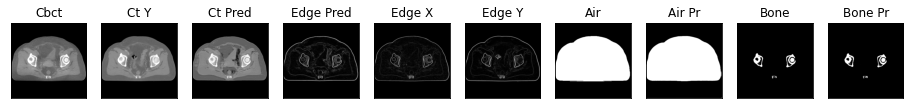

181it [01:09,  2.67it/s]

ssim score = 0.801305890083313
psnr score = 24.009563446044922
snr score = 14.882850646972656
mae error = 0.02544177509844303
air dice score = 0.9953263297212374
bone dice score = 0.9210923102710489
contour dice score = 0.4888888895511627


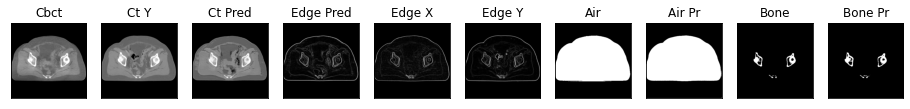

182it [01:10,  2.29it/s]

ssim score = 0.7876366376876831
psnr score = 22.560766220092773
snr score = 13.361615180969238
mae error = 0.02905670739710331
air dice score = 0.9947502070485522
bone dice score = 0.8912863070561974
contour dice score = 0.5004887580871582


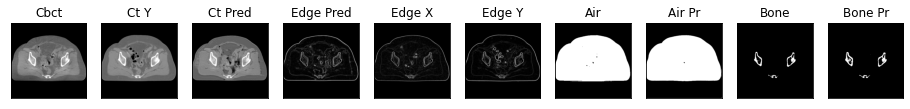

183it [01:10,  2.39it/s]

ssim score = 0.7780562043190002
psnr score = 22.50715446472168
snr score = 13.290010452270508
mae error = 0.02960287593305111
air dice score = 0.9935931442562785
bone dice score = 0.9065498539860961
contour dice score = 0.49358341097831726


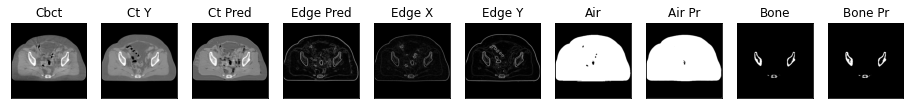

184it [01:11,  2.47it/s]

ssim score = 0.7696596384048462
psnr score = 22.826711654663086
snr score = 13.674480438232422
mae error = 0.02965671755373478
air dice score = 0.9942700933887285
bone dice score = 0.9099044132619503
contour dice score = 0.5140601992607117


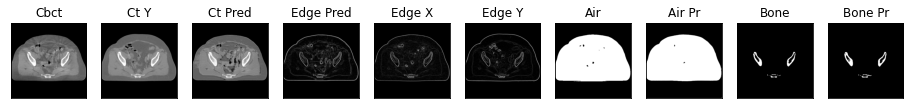

185it [01:11,  2.53it/s]

ssim score = 0.7675151824951172
psnr score = 22.88072395324707
snr score = 13.783589363098145
mae error = 0.029746519401669502
air dice score = 0.9945487179145046
bone dice score = 0.9207295685738209
contour dice score = 0.551243782043457


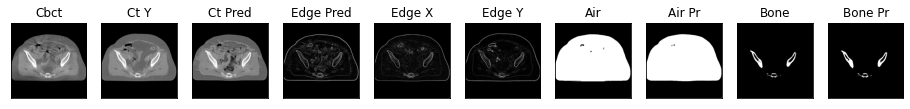

186it [01:12,  2.57it/s]

ssim score = 0.7643916606903076
psnr score = 22.299365997314453
snr score = 13.266660690307617
mae error = 0.031468406319618225
air dice score = 0.9946652035089378
bone dice score = 0.9181399494886623
contour dice score = 0.531434178352356


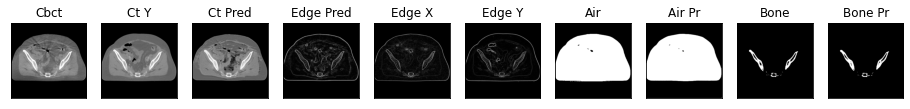

187it [01:12,  2.60it/s]

ssim score = 0.7601374387741089
psnr score = 22.10184097290039
snr score = 13.141993522644043
mae error = 0.03247438371181488
air dice score = 0.9949753358522283
bone dice score = 0.9047749725589356
contour dice score = 0.5145391821861267


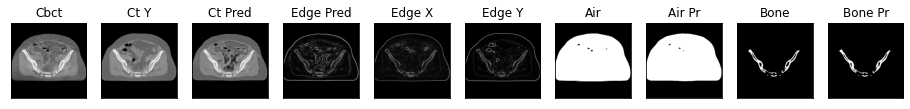

188it [01:12,  2.62it/s]

ssim score = 0.7591792941093445
psnr score = 22.2613525390625
snr score = 13.297216415405273
mae error = 0.032135508954524994
air dice score = 0.9948030154218437
bone dice score = 0.8854152128417946
contour dice score = 0.5173255205154419


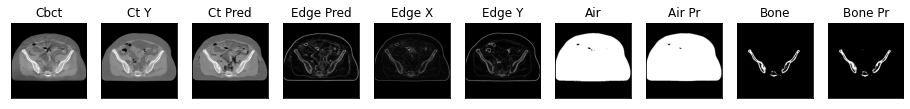

189it [01:13,  2.64it/s]

ssim score = 0.7524500489234924
psnr score = 21.979806900024414
snr score = 12.993494033813477
mae error = 0.03296102583408356
air dice score = 0.9953061935034654
bone dice score = 0.9046779661029875
contour dice score = 0.5016981959342957


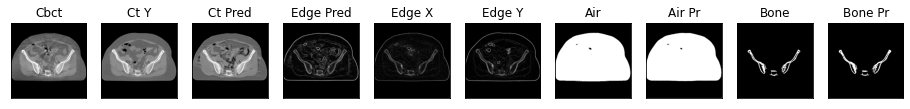

190it [01:13,  2.65it/s]

ssim score = 0.7557663321495056
psnr score = 22.312332153320312
snr score = 13.337651252746582
mae error = 0.032262589782476425
air dice score = 0.9954820528222821
bone dice score = 0.8977288757243937
contour dice score = 0.5108433961868286


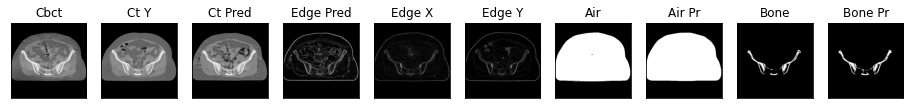

191it [01:14,  2.58it/s]


In [44]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [45]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [46]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [47]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:10, 18.62it/s]


(0.7968837300520293,
 22.379824523526338,
 13.384096470178735,
 0.03495880397748573,
 0.9949212116092511,
 0.8928706966352963,
 0.5118814127919562,
 0.4774869109947644,
 0.5638743455497383)

In [48]:
# import torchvision.models as models
# models.vgg16(pretrained=True)